<a href="https://colab.research.google.com/github/galdir/PGA_regression_with_PSA_clusters/blob/main/paper_peak_ground_acceleration_regression_with_psa_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install geopandas


In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 9.5 MB/s eta 0:00:00


In [ ]:
pip install scikeras[tensorflow]

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

import geopandas as gpd

from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold


from sklearn.impute import SimpleImputer

#import sklearn
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor


from yellowbrick.cluster import SilhouetteVisualizer

import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
#tf.keras.utils.plot_model
from tensorflow.keras.utils import plot_model
#from keras.wrappers.scikit_learn import KerasRegressor
#from scikeras.wrappers import KerasRegressor
import keras_tuner as kt

from scipy import stats

import visualkeras


import pickle
#from joblib import dump, load
import joblib
import os




In [ ]:
tf.random.set_seed(42)


In [ ]:
project_path = '/content/drive/MyDrive/project Mexico Earthquake Analysis/'

In [ ]:
df_raw = pd.read_csv(project_path + '/terremotos - cleaned and with more atributes - locations checked.csv')

In [ ]:
df_raw.shape

(1663, 28)

In [ ]:
df_psa_merged=pd.read_csv(project_path + '/espectros/psa_merged.csv')

# Remove registers from stations without psa data

In [ ]:
columns = df_psa_merged.columns
station_keys = []

for i in range(0, len(columns)):
  col_split=columns[i].split("-")
  if(columns[i] == 'period'):
    continue
  #print(columns[i][:4])
  station_keys.append(columns[i][:4])
  #print(station_key)

station_keys_set = set(station_keys)

print(station_keys_set)

{'TXS4', 'SCCB', 'ACAD', 'CAYR', 'OCLL', 'SXPU', 'LANE', 'CHPA', 'GALE', 'SCT2', 'NUX2', 'ACAM', 'VIGA', 'SAPP', 'OXTO', 'DFVG', 'TXS2', 'CUP2', 'DFRO', 'OXAL', 'XALA', 'SLU2', 'CUIP', 'ZACA', 'ACAZ', 'NILT', 'OXJM', 'COYQ', 'PBP2', 'COMD', 'OXAE', 'PMOP', 'FEPP', 'TNLP', 'GDLP', 'AGCA', 'TXSO', 'CHI1', 'AZIH', 'CDAO', 'SODO', 'RFPP', 'TX5A', 'TXCL', 'MADI', 'RABO', 'SLUI', 'TEAC', 'THEZ', 'OXPM', 'MARU', 'PRJS', 'PNTP', 'ACAR', 'TACY', 'MADR', 'CUMV', 'TLHB', 'LMPP', 'VILE', 'CLON', 'OMTP', 'TAMA', 'PMOS', 'OXLC', 'MIHL', 'CAYA', 'OXXO', 'PZPU', 'COLL', 'ATYC', 'NITA', 'TGBT', 'APAT', 'CAOO', 'CANA', 'GDLC', 'CSER', 'SUCH', 'CUP4', 'HMTT', 'VNTA', 'TOTO', 'PRJP', 'SNJE', 'CU01', 'COMA', 'PUVA', 'SCT1', 'OZST', 'CUP1', 'PARS', 'CCCL', 'CTCL', 'CDAF', 'RIOG', 'POZU', 'CDGU', 'CALE', 'CUP3', 'BHPP', 'SCRU', 'OXCU', 'OCTT', 'CPDR', 'COYC', 'CAOT', 'VHSA', 'TXS1', 'ACAP', 'MSAS', 'OXPC', 'JPSK', 'SMR2', 'JAMI', 'FICA', 'ACAS', 'COPL', 'SRPU', 'OAXM', 'SLPA', 'PET2', 'PROM', 'ACAN', 'OXBJ',

In [ ]:
psa_station_keys_set = station_keys_set

In [ ]:
len(psa_station_keys_set)

148

In [ ]:
pga_station_keys_set = df_raw.station_key.unique()

In [ ]:
len(pga_station_keys_set)

172

In [ ]:
pga_stations_without_psa = set(pga_station_keys_set) - set(psa_station_keys_set)

In [ ]:
len(pga_stations_without_psa)

24

In [ ]:
pga_stations_with_psa = set(pga_station_keys_set) - pga_stations_without_psa

In [ ]:
len(pga_stations_with_psa)

148

In [ ]:
df_raw.shape

(1663, 28)

In [ ]:
df_raw.query('station_key in @pga_stations_with_psa').shape

(1614, 28)

In [ ]:
df_stations_with_PSA = df_raw.query('station_key in @pga_stations_with_psa')

In [ ]:
df_stations_with_PSA.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth'],
      dtype='object')

In [ ]:
df_stations_with_PSA.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662],
           dtype='int64', length=1614)

In [ ]:
df_stations_with_PSA.reset_index(inplace=True, drop=True)

In [ ]:
df_stations_with_PSA.head()

date      time  magnitude  institution entity station_key  \
0  2018-02-16  23:39:39        7.2  I de I-UNAM    GRO        SLU2   
1  2018-02-16  23:39:39        7.2  I de I-UNAM    OAX        SMLC   
2  2018-02-16  23:39:39        7.2  I de I-UNAM    MIC        SNJE   
3  2018-02-16  23:39:39        7.2  I de I-UNAM    VER        SODO   
4  2018-02-16  23:39:39        7.2  I de I-UNAM    GRO        SUCH   

             station_name  peak_ground_acceleration quality          file  \
0   SAN LUIS DE LA LOMA 2                      2.94       A  SLU21802.161   
1  SAN MARTIN LOS CANSECO                     23.38       A  SMLC1802.161   
2            SAN JERONIMO                      3.51       A  SNJE1802.161   
3      SOLEDAD DE DOBLADO                      8.76       A  SODO1802.161   
4               EL SUCHIL                      4.41       A  SUCH1802.161   

   ...  duration incidence_angle  hypocentral_distance     azimuth  \
0  ...     133.0        2.750835            333.384163  109.987575   
1  ...     210.0        6.296819            145.880088  251.209162   
2  ...     157.0        2.106481            435.294153  124.990997   
3  ...     270.0        2.580599            355.360380  209.494929   
4  ...     138.0        3.042759            301.424949  111.011136   

   angle_to_the_nearest_horizontal_sensor calculated_epicentral_distance  \
0                               21.215506                     333.015189   
1                               19.712860                     145.432447   
2                               36.743086                     435.294924   
3                               28.090209                     355.845160   
4                               22.227069                     301.327132   

   calculated_hypocentral_distance  calculated_incidence_angle  \
0                       333.399334                    2.750710   
1                       146.309933                    6.278245   
2                       435.588879                    2.105055   
3                       356.204686                    2.574478   
4                       301.751621                    3.039462   

   source_off_shore  calculated_azimuth  
0             False          -68.901392  
1             False           70.398457  
2             False          -53.423946  
3             False           28.236455  
4             False          -67.894639  

[5 rows x 28 columns]

In [ ]:
df = df_stations_with_PSA

In [ ]:
df.shape

(1614, 28)

# Data Description and Analysis

In [ ]:
df.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1614 entries, 0 to 1613
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   date                                    1614 non-null   object 
 1   time                                    1614 non-null   object 
 2   magnitude                               1614 non-null   float64
 3   institution                             1614 non-null   object 
 4   entity                                  1614 non-null   object 
 5   station_key                             1614 non-null   object 
 6   station_name                            1614 non-null   object 
 7   peak_ground_acceleration                1614 non-null   float64
 8   quality                                 1614 non-null   object 
 9   file                                    1614 non-null   object 
 10  epicentral_distance                     1614 non-null   int6

In [ ]:
df.station_key.unique().shape

(148,)

In [ ]:
df.date.max()

'2018-02-19'

In [ ]:
df.date =  pd.to_datetime(df.copy().date)

<ipython-input-34-2070545d87ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.date =  pd.to_datetime(df.copy().date)


[Text(0.5, 0, 'Hypocentral Distance (km)')]

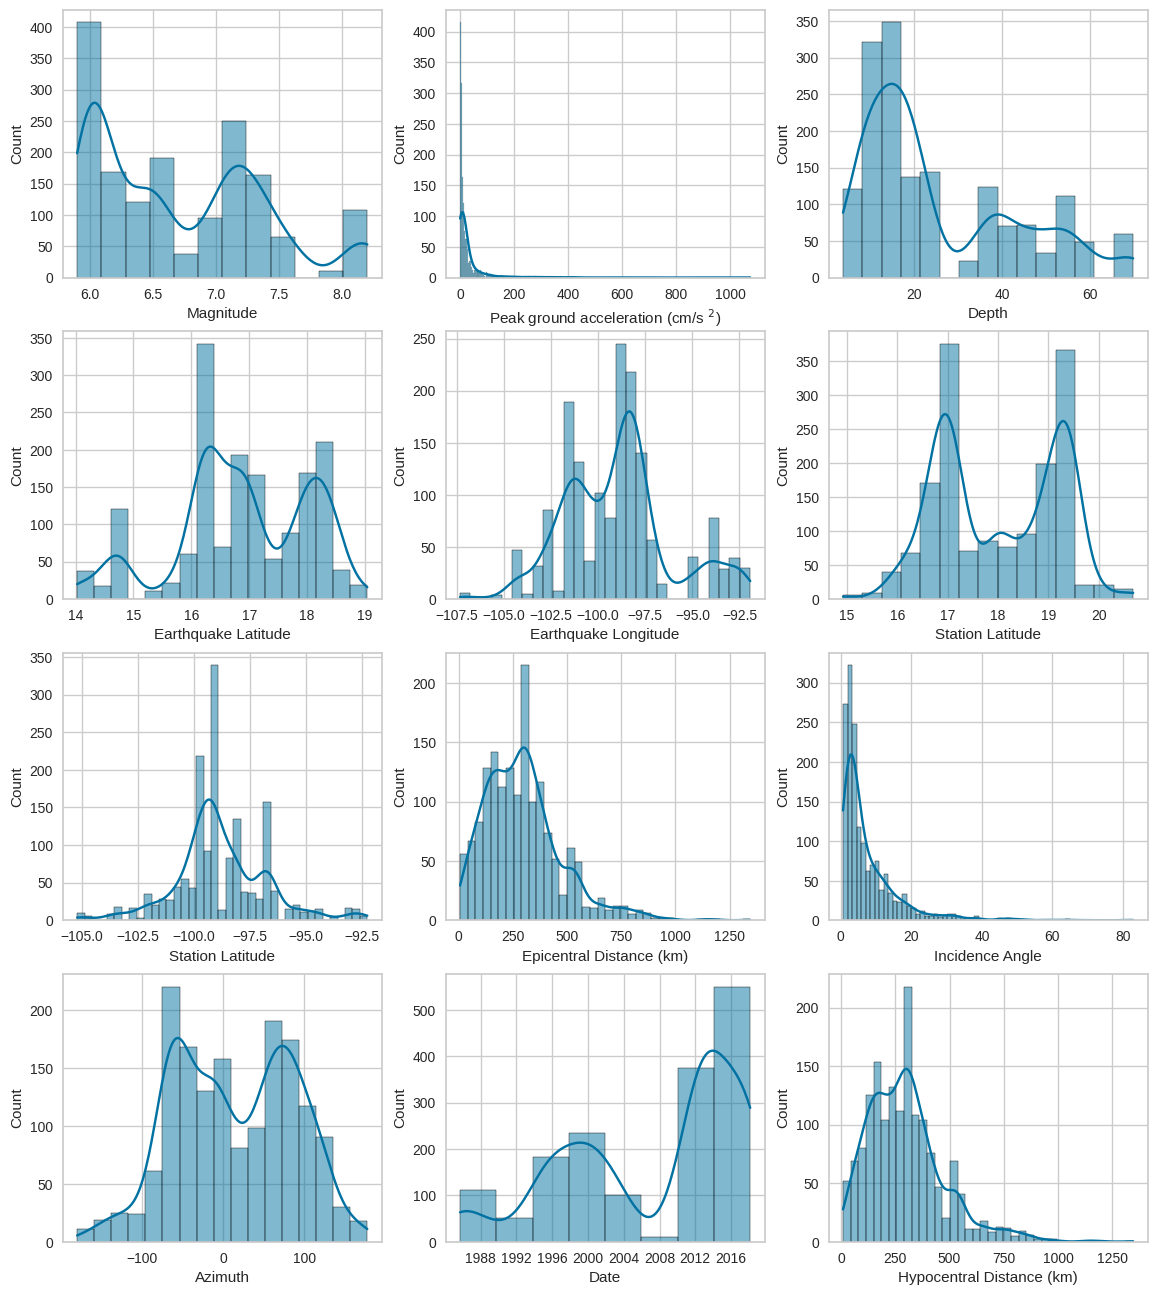

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(14, 16))
sns.histplot(data=df, x="magnitude", kde=True, ax=axs[0, 0])
axs[0,0].set(xlabel="Magnitude")

sns.histplot(data=df, x="peak_ground_acceleration", kde=True, ax=axs[0, 1])
axs[0,1].set(xlabel="Peak ground acceleration (cm/s $^2$)")

sns.histplot(data=df, x="depth", kde=True, ax=axs[0, 2])
axs[0,2].set(xlabel="Depth")

sns.histplot(data=df, x="earthquake_latitude", kde=True, ax=axs[1, 0])
axs[1,0].set(xlabel="Earthquake Latitude")

sns.histplot(data=df, x="earthquake_longitude", kde=True, ax=axs[1, 1])
axs[1,1].set(xlabel="Earthquake Longitude")

sns.histplot(data=df, x="station_latitude", kde=True, ax=axs[1, 2])
axs[1,2].set(xlabel="Station Latitude")

sns.histplot(data=df, x="station_longitude", kde=True, ax=axs[2, 0])
axs[2, 0].set(xlabel="Station Latitude")

sns.histplot(data=df, x="calculated_epicentral_distance", kde=True, ax=axs[2, 1])
axs[2, 1].set(xlabel="Epicentral Distance (km)")

#sns.histplot(data=df, x="duration", kde=True, ax=axs[3, 0])
sns.histplot(data=df, x="incidence_angle", kde=True, ax=axs[2, 2])
axs[2, 2].set(xlabel="Incidence Angle")

#sns.histplot(data=df, x="hypocentral_distance", kde=True, ax=axs[3, 2])
sns.histplot(data=df, x="calculated_azimuth", kde=True, ax=axs[3, 0])
axs[3, 0].set(xlabel="Azimuth")

sns.histplot(data=df, x="date", kde=True, bins=8, ax=axs[3, 1])
axs[3, 1].set(xlabel="Date")

sns.histplot(data=df, x="calculated_hypocentral_distance", kde=True, ax=axs[3, 2])
axs[3, 2].set(xlabel="Hypocentral Distance (km)")



In [ ]:
df.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth'],
      dtype='object')

Text(0, 0.5, 'Peak ground acceleration (cm/s $^2$)')

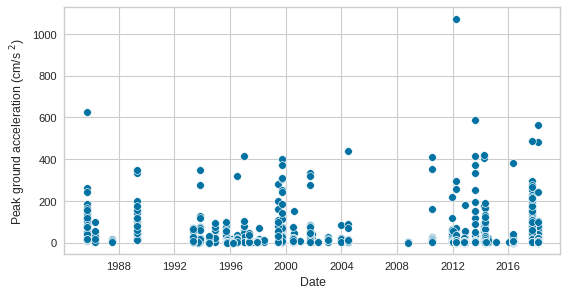

In [ ]:
plt.figure(figsize=(8, 4), dpi=80)
sns.scatterplot(data=df, x='date', y='peak_ground_acceleration')
plt.xlabel('Date')
plt.ylabel('Peak ground acceleration (cm/s $^2$)')

Text(0, 0.5, 'Peak ground acceleration (cm/s $^2$)')

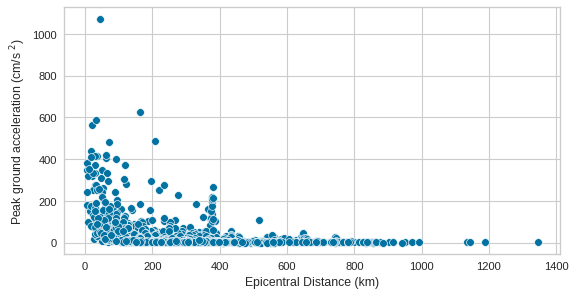

In [ ]:

plt.figure(figsize=(8, 4), dpi=80)
sns.scatterplot(data=df, x='calculated_epicentral_distance', y='peak_ground_acceleration')
plt.xlabel('Epicentral Distance (km)')
plt.ylabel('Peak ground acceleration (cm/s $^2$)')


Text(0, 0.5, 'Peak ground acceleration (cm/s $^2$)')

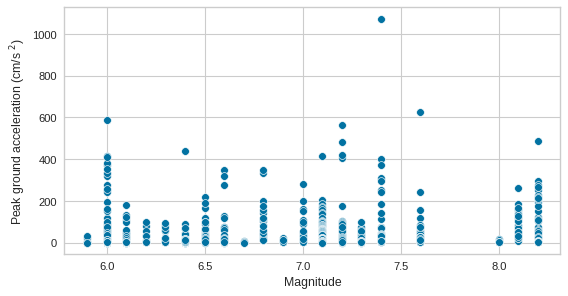

In [ ]:
plt.figure(figsize=(8, 4), dpi=80)
sns.scatterplot(data=df, x='magnitude', y='peak_ground_acceleration')
plt.xlabel('Magnitude')
plt.ylabel('Peak ground acceleration (cm/s $^2$)')

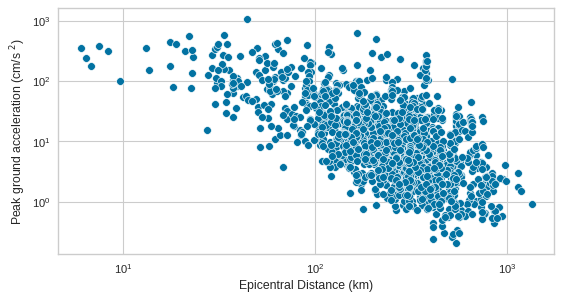

In [ ]:
plt.figure(figsize=(8, 4), dpi=80)
sns.scatterplot(data=df, x='calculated_epicentral_distance', y='peak_ground_acceleration')
plt.xlabel('Epicentral Distance (km)')
plt.ylabel('Peak ground acceleration (cm/s $^2$)')
plt.xscale('log')
plt.yscale('log')

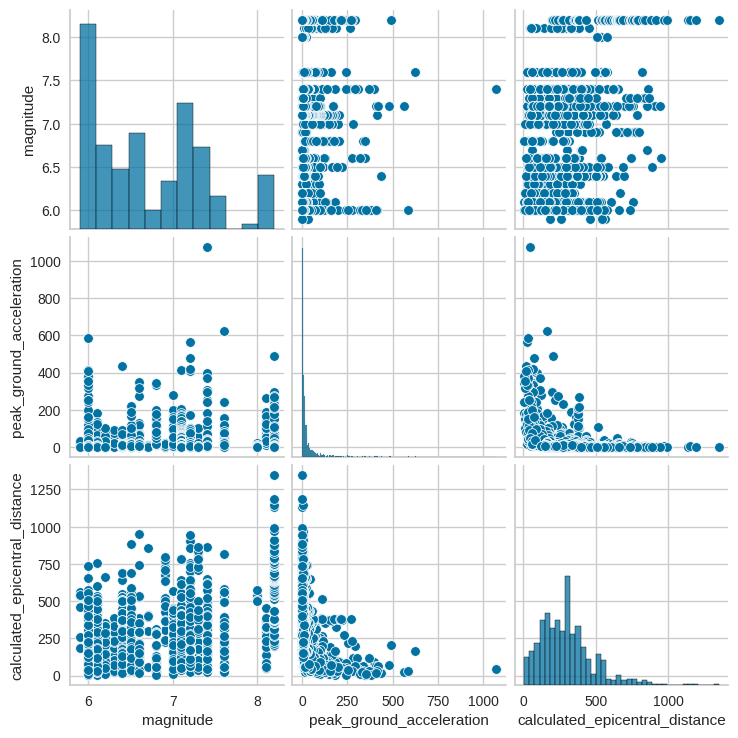

In [ ]:
sns.pairplot(df[['magnitude','peak_ground_acceleration', 'calculated_epicentral_distance']])

## map

In [ ]:
df.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth'],
      dtype='object')

In [ ]:
map = gpd.read_file('/content/drive/MyDrive/project Mexico Earthquake Analysis/mex_admbndl_admALL_govmex_itos_20210618.shx')

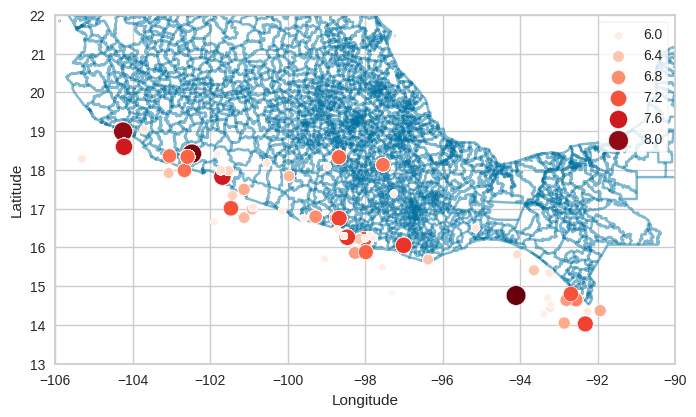

In [ ]:
ax1 = map.plot(figsize=(8,6), alpha=0.5)

g = sns.scatterplot(ax=ax1,
                data=df,
                x='earthquake_longitude',
                y='earthquake_latitude',
                size='magnitude',
                hue='magnitude',
                sizes=(20, 200),
                #marker=(8,1,0),
                zorder=2,
                palette=sns.color_palette("Reds", as_cmap=True))

#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.legend(frameon=True)

ax1.set(xlabel='Longitude', ylabel='Latitude')
plt.xlim([-106, -90])
plt.ylim([13, 22])

plt.show()

In [ ]:
df[(df.earthquake_latitude>17.5) & (df.earthquake_latitude<19)& (df.earthquake_longitude>-98) & (df.earthquake_longitude<-96)]

date      time  magnitude  institution entity station_key  \
214 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        ACAD   
215 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        ACAR   
216 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        ACAZ   
217 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        ACPD   
218 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        AGCA   
219 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        ATYC   
220 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        COMD   
221 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        COPL   
222 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        COYC   
223 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        COYQ   
224 1999-06-15  20:42:07        7.0  I de I-UNAM    PUE        CSER   
225 1999-06-15  20:42:07        7.0  I de I-UNAM    DIF        CUP5   
226 1999-06-15  20:42:07        7.0  I de I-UNAM    PUE        CHFL   
227 1999-06-15  20:42:07        7.0  I de I-UNAM    DIF        DFRO   
228 1999-06-15  20:42:07        7.0  I de I-UNAM    DIF        DFVG   
229 1999-06-15  20:42:07        7.0  I de I-UNAM    OAX        JAMI   
230 1999-06-15  20:42:07        7.0  I de I-UNAM    OAX        LANE   
231 1999-06-15  20:42:07        7.0  I de I-UNAM    MEX        MADR   
232 1999-06-15  20:42:07        7.0  I de I-UNAM    OAX        OAXM   
233 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        OCLL   
234 1999-06-15  20:42:07        7.0  I de I-UNAM    OAX        OMTP   
235 1999-06-15  20:42:07        7.0  I de I-UNAM    OAX        OXLC   
236 1999-06-15  20:42:07        7.0  I de I-UNAM    OAX        PANG   
237 1999-06-15  20:42:07        7.0  I de I-UNAM    DIF        PENR   
238 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        PET2   
239 1999-06-15  20:42:07        7.0  I de I-UNAM    PUE        PHPU   
240 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        POZU   
241 1999-06-15  20:42:07        7.0  I de I-UNAM    PUE        RABO   
242 1999-06-15  20:42:07        7.0  I de I-UNAM    OAX        RIOG   
243 1999-06-15  20:42:07        7.0  I de I-UNAM    DIF        SCT1   
244 1999-06-15  20:42:07        7.0  I de I-UNAM    DIF        SCT2   
245 1999-06-15  20:42:07        7.0  I de I-UNAM    OAX        SMLC   
246 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        SMR2   
247 1999-06-15  20:42:07        7.0  I de I-UNAM    OAX        TAMA   
248 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        TEAC   
249 1999-06-15  20:42:07        7.0  I de I-UNAM    DIF        TLHB   
250 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        TNLP   
251 1999-06-15  20:42:07        7.0  I de I-UNAM    MEX        TXS1   
252 1999-06-15  20:42:07        7.0  I de I-UNAM    MEX        TXS2   
253 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        UNIO   
254 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        VIGA   
255 1999-06-15  20:42:07        7.0  I de I-UNAM    GRO        VNTA   

                    station_name  peak_ground_acceleration quality  \
214       ACAPULCO ESCUELA DIANA                     24.50       A   
215        ACAPULCO RENACIMIENTO                     17.99       A   
216            ACAPULCO LA ZANJA                     23.15       A   
217     ACAPULCO DIANA POZO 63 M                      5.05       A   
218                 AGUACALIENTE                     11.43       A   
219                       ATOYAC                      7.35       A   
220                 LA COMUNIDAD                     16.72       A   
221                       COPALA                     14.75       A   
222                       COYUCA                     12.23       A   
223                   COYUQUILLA                     10.01       A   
224                CIUDAD SERDAN                    199.13       A   
225                 IDEI PATIO 5                     11.85       A   
226          CHILA DE LAS FLORES              

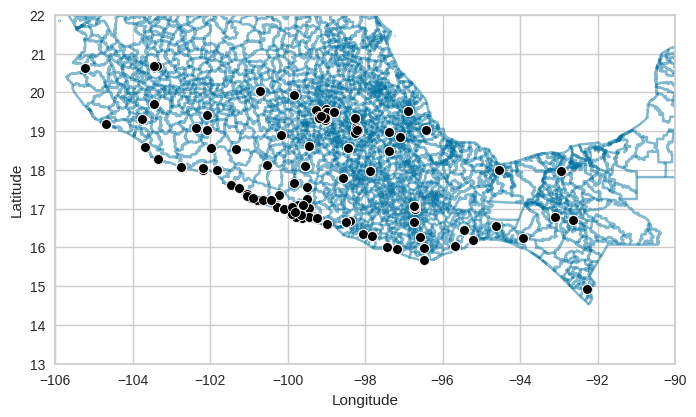

In [ ]:
ax1 = map.plot(figsize=(8,6), alpha=0.5)

sns.scatterplot(ax=ax1,
                data=df,
                x='station_longitude',
                y='station_latitude',
                zorder=2,
                color='black',
                s=50)
ax1.set(xlabel='Longitude', ylabel='Latitude')

#plt.legend(labels=['','Station'])
plt.xlim([-106, -90])
plt.ylim([13, 22])
plt.show()

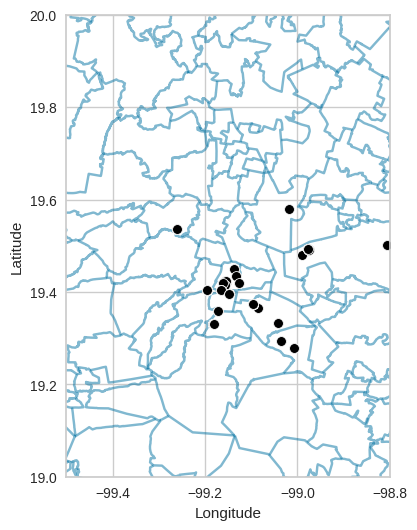

In [ ]:
ax1 = map.plot(figsize=(8,6), alpha=0.5)

sns.scatterplot(ax=ax1,
                data=df,
                x='station_longitude',
                y='station_latitude',
                zorder=2,
                color='black',
                s=50)
ax1.set(xlabel='Longitude', ylabel='Latitude')

#plt.legend(labels=['','Station'])
plt.xlim([-99.5, -98.8])
plt.ylim([19, 20])
plt.show()

## One event

In [ ]:
one_event = df[df['date']=='2017-09-19 00:00:00']

In [ ]:
one_event.shape

(73, 28)

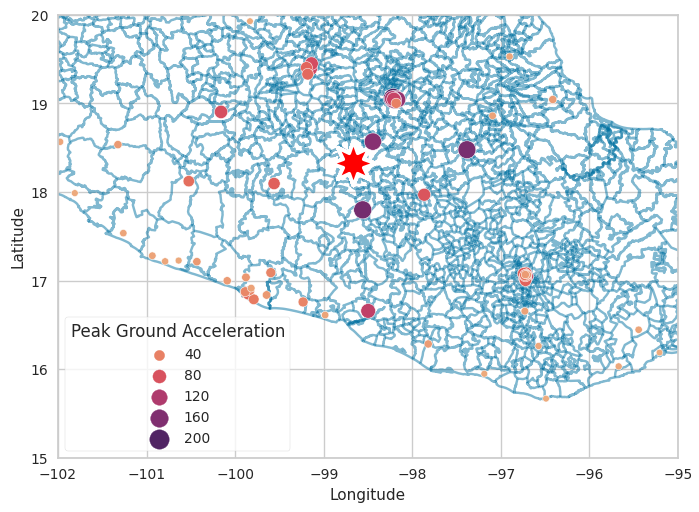

In [ ]:

ax1 = map.plot(figsize=(8, 6), alpha=0.5)
ax1.set(xlabel='Longitude', ylabel='Latitude')

sns.scatterplot(ax=ax1,
                data=one_event,
                x='earthquake_longitude',
                y='earthquake_latitude',
                color='red',
                s=1000,
                zorder=2,
                #palette=pal,
                marker=(8,1,0))
sns.scatterplot(ax=ax1,
                data=one_event,
                x='station_longitude',
                y='station_latitude',
                zorder=2,
                hue='peak_ground_acceleration',
                size='peak_ground_acceleration',
                palette=sns.color_palette("flare", as_cmap=True),
                sizes=(20, 200))
plt.xlim([-102, -95])
plt.ylim([15, 20])
#sns.set_style('darkgrid', {'legend.frameon':True})
sns.set_style("whitegrid")
plt.legend(frameon=True, title='Peak Ground Acceleration')



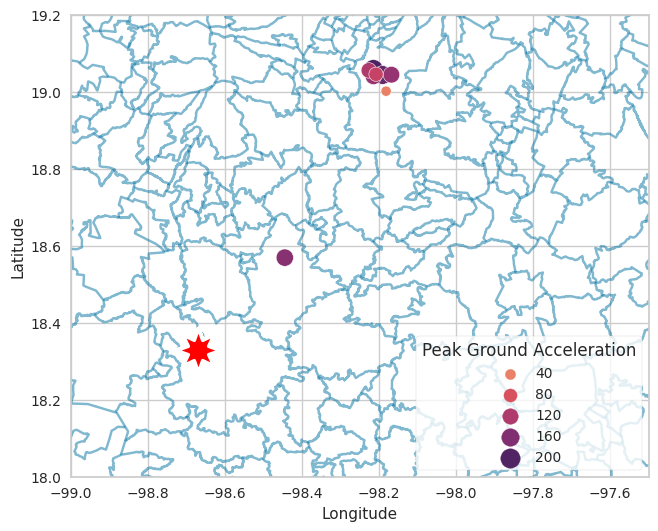

In [ ]:

ax1 = map.plot(figsize=(8, 6), alpha=0.5)
ax1.set(xlabel='Longitude', ylabel='Latitude')

sns.scatterplot(ax=ax1,
                data=one_event,
                x='earthquake_longitude',
                y='earthquake_latitude',
                color='red',
                s=1000,
                zorder=2,
                #palette=pal,
                marker=(8,1,0))
sns.scatterplot(ax=ax1,
                data=one_event,
                x='station_longitude',
                y='station_latitude',
                zorder=2,
                hue='peak_ground_acceleration',
                size='peak_ground_acceleration',
                palette=sns.color_palette("flare", as_cmap=True),
                sizes=(20, 200))
plt.xlim([-99, -97.5])
plt.ylim([18, 19.2])
#sns.set_style('darkgrid', {'legend.frameon':True})
plt.legend(frameon=True, title='Peak Ground Acceleration', loc='lower right')

##PSA

In [ ]:
df_psa_merged.shape

(1000, 1653)

In [ ]:
df_psa_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 1653 entries, period to XALA1802161-V
dtypes: float64(1653)
memory usage: 12.6 MB


In [ ]:
df_psa_merged.columns

Index(['period', 'ACAP8509191-EW', 'ACAP8509191-NS', 'ACAP8509191-V',
       'ACAS8509191-EW', 'ACAS8509191-NS', 'ACAS8509191-V', 'APAT8509191-EW',
       'APAT8509191-NS', 'APAT8509191-V',
       ...
       'TNLP1802161-V', 'VHSA1802161-EW', 'VHSA1802161-NS', 'VHSA1802161-V',
       'VIGA1802164-EW', 'VIGA1802164-NS', 'VIGA1802164-V', 'XALA1802161-EW',
       'XALA1802161-NS', 'XALA1802161-V'],
      dtype='object', length=1653)

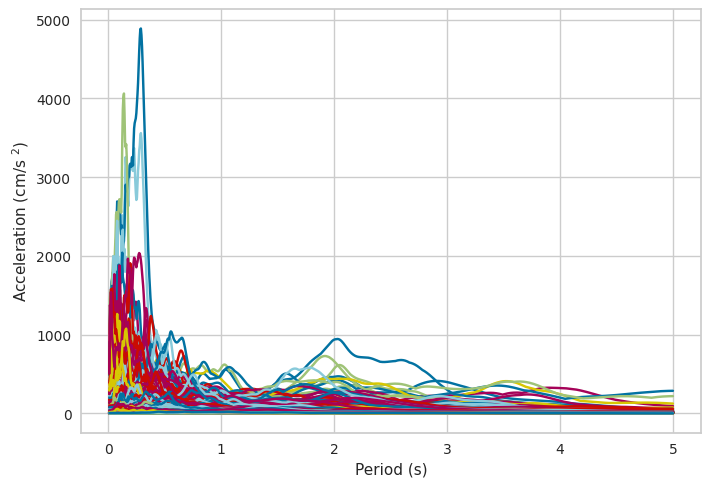

In [ ]:
plt.plot(df_psa_merged['period'], df_psa_merged.iloc[:, 1:-1])
#df_merged.plot(legend=False)
#plt.plot(df1['period'], df_merge_all.values)
plt.xlabel('Period (s)')
plt.ylabel('Acceleration (cm/s $^2$)')
plt.show()

[16, 17, 18, 19, 20, 21, 579, 580, 581, 708, 709, 710, 900, 901, 902]


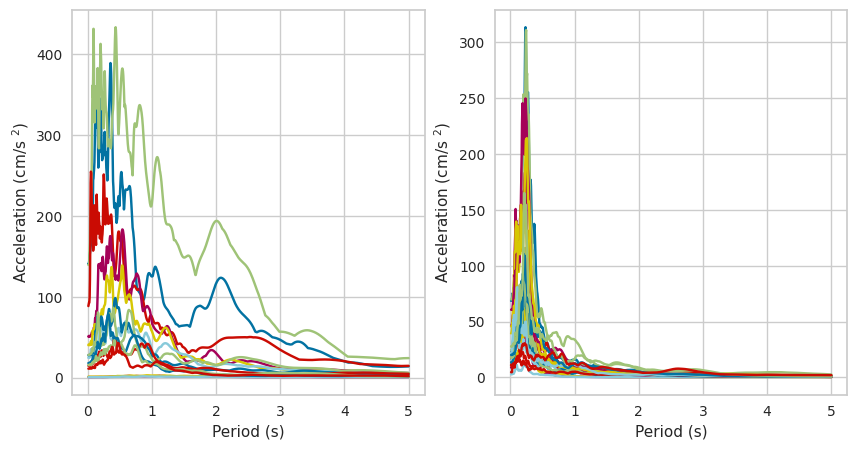

In [ ]:
columns = df_psa_merged.columns


fig, axs = plt.subplots(1, 2, figsize=(10,5))

indexs_station = []

for i in range(len(columns)):
  #column_split = columns[i].split("-")
  actual_station_key = columns[i][:4]
  #orientation = columns[i].split("-")[-1]
  if actual_station_key == 'CALE':
    indexs_station.append(i)

print(indexs_station)

axs[0].plot(df_psa_merged['period'].values, df_psa_merged.iloc[:, indexs_station].values)
axs[0].set_xlabel('Period (s)')
axs[0].set_ylabel('Acceleration (cm/s $^2$)')

indexs_station = []


for i in range(len(columns)):
  #column_split = columns[i].split("-")
  actual_station_key = columns[i][:4]
  #orientation = columns[i].split("-")[-1]
  if actual_station_key == 'ACAD':
    indexs_station.append(i)

axs[1].plot(df_psa_merged['period'], df_psa_merged.iloc[:, indexs_station])
axs[1].set_xlabel('Period (s)')
axs[1].set_ylabel('Acceleration (cm/s $^2$)')

plt.show()

# Preprocessing

## Remove outliers

In [ ]:
selected_atributes = ['magnitude', 'calculated_epicentral_distance', 'peak_ground_acceleration']

selected_atributes_large = ['magnitude',
             'calculated_epicentral_distance', 'depth', 'calculated_incidence_angle',
             'calculated_hypocentral_distance', 'peak_ground_acceleration', 'source_off_shore',
             'calculated_azimuth']


clf = LocalOutlierFactor(contamination=0.001, n_neighbors=200)

scaler = StandardScaler()
outliers_classess = clf.fit_predict(scaler.fit_transform(df[selected_atributes_large]))
#outliers_classess = clf.fit_predict(df[selected_atributes])


In [ ]:
outliers = np.where(outliers_classess == -1)
print(outliers)
print(len(outliers[0]))

(array([464, 906]),)
2


In [ ]:
outliers = outliers[0]

In [ ]:
df[['date','station_key'] + selected_atributes_large].iloc[outliers]

date station_key  magnitude  calculated_epicentral_distance  depth  \
464 1985-09-21        PARS        7.6                      164.676001   17.0   
906 2012-03-20        SJLL        7.4                       43.806051   16.0   

     calculated_incidence_angle  calculated_hypocentral_distance  \
464                    5.893938                       165.551156   
906                   20.064536                        46.636575   

     peak_ground_acceleration  source_off_shore  calculated_azimuth  
464                    625.78             False          108.760233  
906                   1073.51              True           -5.795153

In [ ]:
#selected_outliers = [482, 938]
selected_outliers = [464, 906]

In [ ]:
selected_outliers

[464, 906]

In [ ]:
df = df.query('index not in @selected_outliers')

In [ ]:
df.shape

(1612, 28)

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df.index

RangeIndex(start=0, stop=1612, step=1)

In [ ]:
df.head()

date      time  magnitude  institution entity station_key  \
0 2018-02-16  23:39:39        7.2  I de I-UNAM    GRO        SLU2   
1 2018-02-16  23:39:39        7.2  I de I-UNAM    OAX        SMLC   
2 2018-02-16  23:39:39        7.2  I de I-UNAM    MIC        SNJE   
3 2018-02-16  23:39:39        7.2  I de I-UNAM    VER        SODO   
4 2018-02-16  23:39:39        7.2  I de I-UNAM    GRO        SUCH   

             station_name  peak_ground_acceleration quality          file  \
0   SAN LUIS DE LA LOMA 2                      2.94       A  SLU21802.161   
1  SAN MARTIN LOS CANSECO                     23.38       A  SMLC1802.161   
2            SAN JERONIMO                      3.51       A  SNJE1802.161   
3      SOLEDAD DE DOBLADO                      8.76       A  SODO1802.161   
4               EL SUCHIL                      4.41       A  SUCH1802.161   

   ...  duration incidence_angle  hypocentral_distance     azimuth  \
0  ...     133.0        2.750835            333.384163  109.987575   
1  ...     210.0        6.296819            145.880088  251.209162   
2  ...     157.0        2.106481            435.294153  124.990997   
3  ...     270.0        2.580599            355.360380  209.494929   
4  ...     138.0        3.042759            301.424949  111.011136   

   angle_to_the_nearest_horizontal_sensor calculated_epicentral_distance  \
0                               21.215506                     333.015189   
1                               19.712860                     145.432447   
2                               36.743086                     435.294924   
3                               28.090209                     355.845160   
4                               22.227069                     301.327132   

   calculated_hypocentral_distance  calculated_incidence_angle  \
0                       333.399334                    2.750710   
1                       146.309933                    6.278245   
2                       435.588879                    2.105055   
3                       356.204686                    2.574478   
4                       301.751621                    3.039462   

   source_off_shore  calculated_azimuth  
0             False          -68.901392  
1             False           70.398457  
2             False          -53.423946  
3             False           28.236455  
4             False          -67.894639  

[5 rows x 28 columns]

## Feature engineering

<Axes: xlabel='incidence_angle', ylabel='Count'>

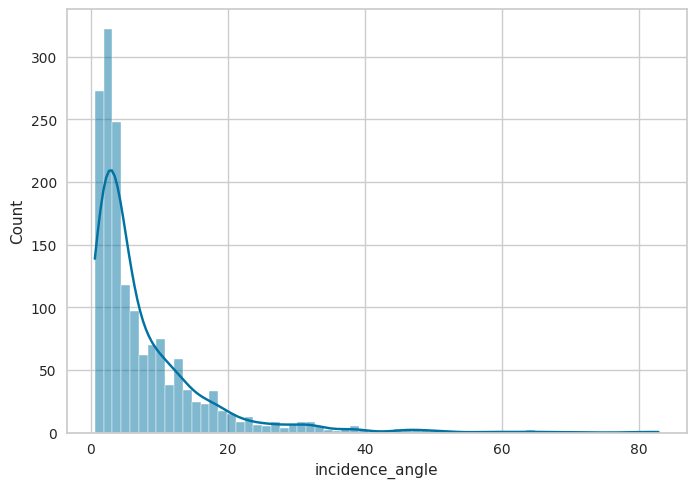

In [ ]:
sns.histplot(x=df.incidence_angle, kde=True)

In [ ]:
df = df.assign(log_incidence_angle=np.log(df.calculated_incidence_angle))

[Text(0.5, 0, 'Log Incidence Angle')]

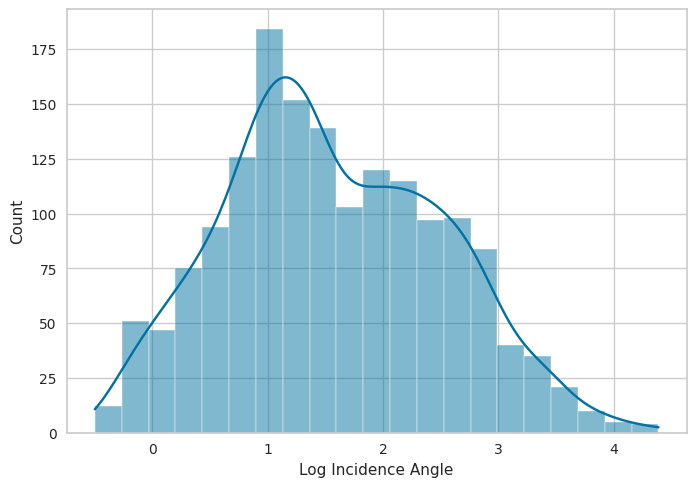

In [ ]:
ax = sns.histplot(x=df.log_incidence_angle, kde=True)
ax.set(xlabel='Log Incidence Angle')

<Axes: xlabel='magnitude', ylabel='Count'>

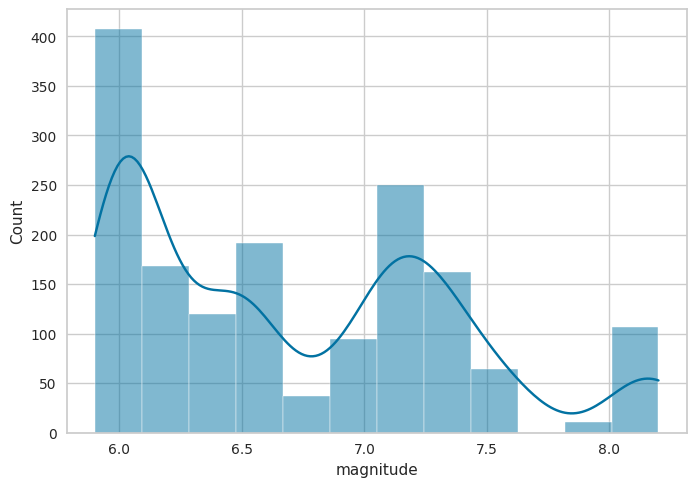

In [ ]:
sns.histplot(x=(df.magnitude), kde=True)

[Text(0.5, 0, 'Magnitude Category')]

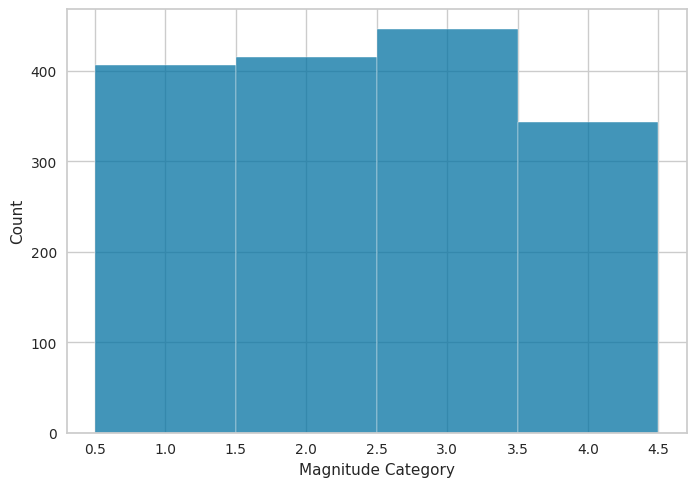

In [ ]:
df["magnitude_cat"] = pd.cut(df["magnitude"],
                             bins=[0., 6.08, 6.5, 7.2, np.inf],
                             #bins=[0., 6.04, 6.3, 6.7, 7.2, np.inf],
                             labels=[1, 2, 3, 4, ])

ax = sns.histplot(x=(df.magnitude_cat))

ax.set(xlabel='Magnitude Category')

In [ ]:
df["magnitude_cat"].value_counts()

3    446
2    415
1    407
4    344
Name: magnitude_cat, dtype: int64

<Axes: xlabel='peak_ground_acceleration', ylabel='Count'>

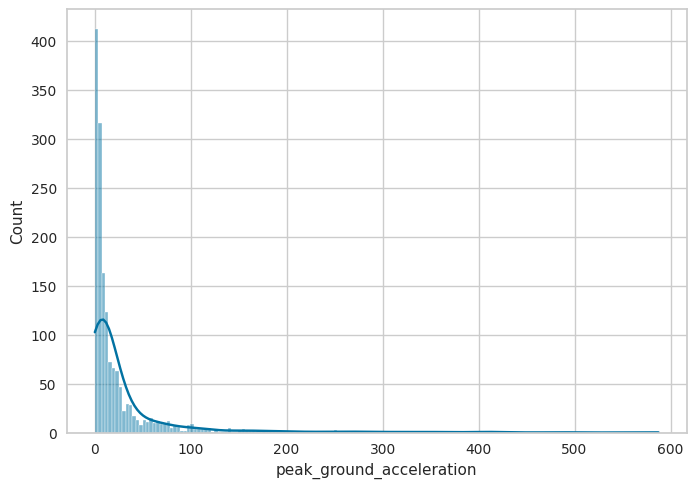

In [ ]:
sns.histplot(x=(df.peak_ground_acceleration), kde=True)

In [ ]:
df["peak_ground_acceleration_cat"] = pd.cut(df.peak_ground_acceleration,
                                            bins=[0., 2, 4, 6, 10, 18, 30, 80, np.inf],
                                            labels=[1, 2, 3, 4, 5, 6, 7, 8])

<Axes: xlabel='peak_ground_acceleration_cat', ylabel='Count'>

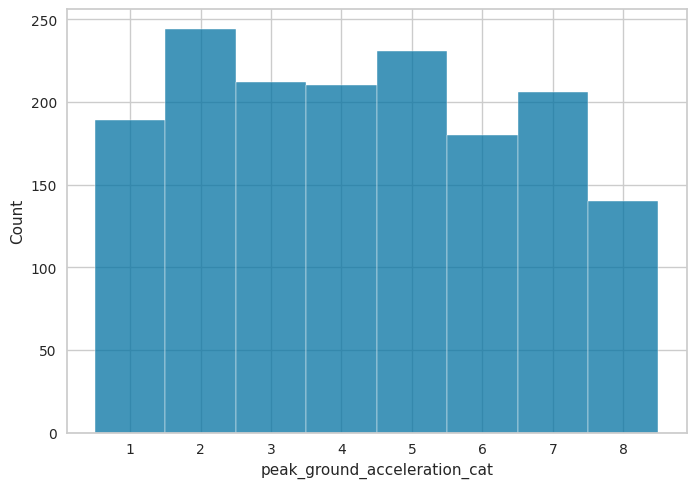

In [ ]:
sns.histplot(x=(df.peak_ground_acceleration_cat))

<Axes: xlabel='calculated_epicentral_distance', ylabel='Count'>

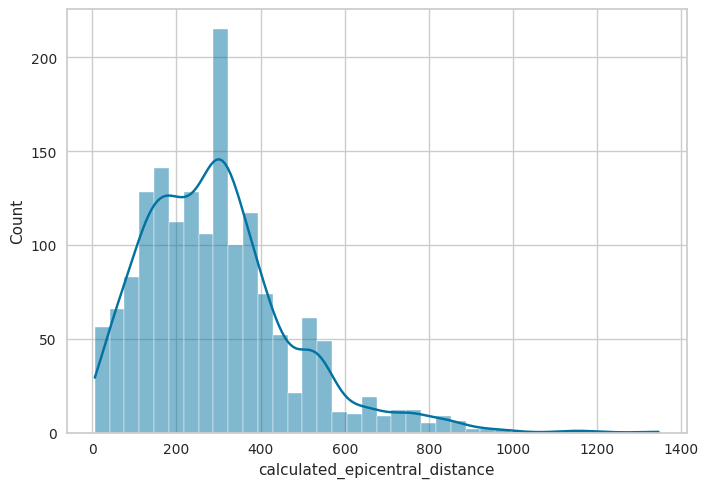

In [ ]:
sns.histplot(x=(df.calculated_epicentral_distance), kde=True)

<Axes: xlabel='calculated_epicentral_distance_cat', ylabel='Count'>

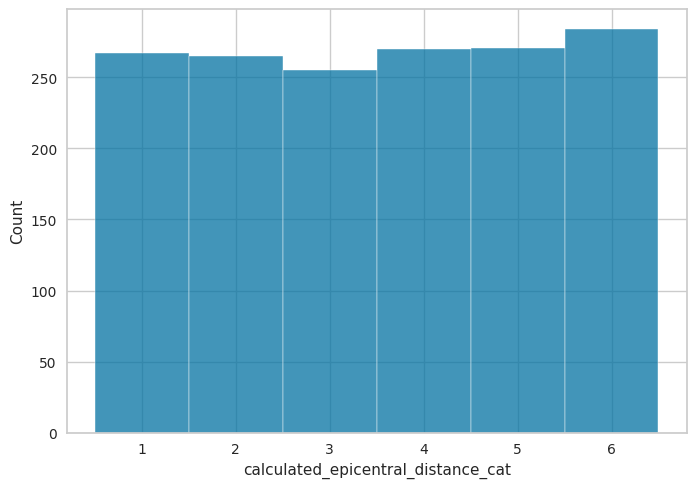

In [ ]:
df["calculated_epicentral_distance_cat"] = pd.cut(df.calculated_epicentral_distance,
                                                  bins=[0., 130, 200, 280, 330, 430, np.inf],
                                                  labels=[1, 2, 3, 4, 5, 6])
sns.histplot(x=(df.calculated_epicentral_distance_cat))

<Axes: xlabel='depth', ylabel='Count'>

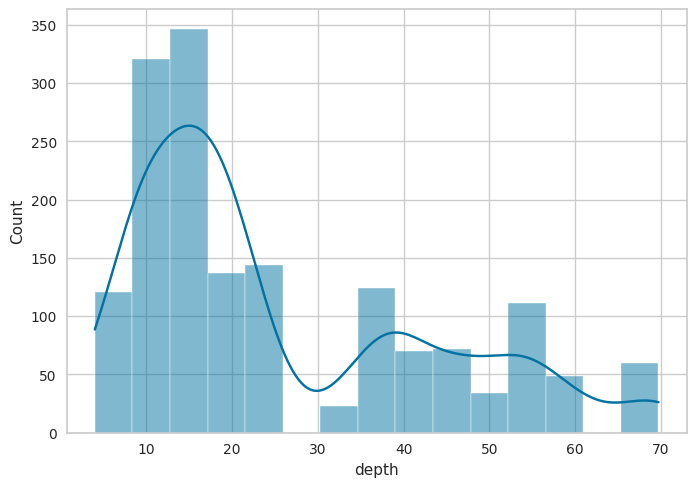

In [ ]:
sns.histplot(x=(df.depth), kde=True)

<Axes: xlabel='depth_cat', ylabel='Count'>

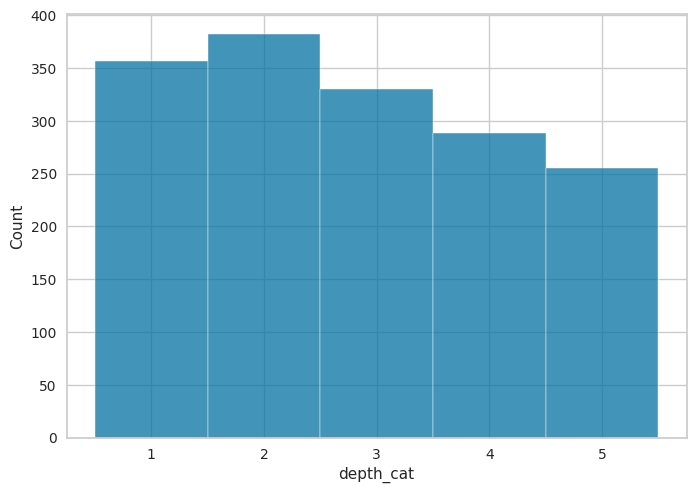

In [ ]:
df["depth_cat"] = pd.cut(df.depth,
                         bins=[0., 10, 16, 30, 46, np.inf],
                         labels=[1, 2, 3, 4, 5])
sns.histplot(x=(df.depth_cat))

## PSA preprocessing

In [ ]:
print(len(station_keys_set))

148


In [ ]:
df_psa_merged.shape

(1000, 1653)

In [ ]:
columns = df_psa_merged.columns

df_merge_spectral_coefs_mean = pd.DataFrame(columns=list(station_keys_set))
df_merge_spectral_mean = pd.DataFrame(columns=list(station_keys_set))
df_merge_horiz_spectral_mean = pd.DataFrame(columns=list(station_keys_set))
df_merge_vertical_spectral_mean = pd.DataFrame(columns=list(station_keys_set))


station_key_index=0
psa_samples = np.zeros(len(station_keys_set))
for station_key in station_keys_set:
  indexs_station_v = []
  indexs_station_ew = []
  indexs_station_ns = []
  v_signals = []
  ew_signals = []
  ns_signals = []
  for i in range(len(columns)):
    #column_split = columns[i].split("-")
    actual_station_key = columns[i][:4]
    orientation = columns[i].split("-")[-1]
    if actual_station_key == station_key:
      #print(station_key)
      psa_samples[station_key_index] = psa_samples[station_key_index] + 1
      if orientation == 'V':
        indexs_station_v.append(i)
        v_signals.append(df_psa_merged.iloc[:, i].values)
        #print(len(v_signals))
      elif orientation == 'EW':
        indexs_station_ew.append(i)
        ew_signals.append(df_psa_merged.iloc[:, i].values)
      elif orientation == 'NS':
        indexs_station_ns.append(i)
        ns_signals.append(df_psa_merged.iloc[:, i].values)
      else:
        print('unknown orientation')
  station_key_index +=1

  v_mean = np.mean(v_signals, axis=0)
  ew_mean = np.mean(ew_signals, axis=0)
  ns_mean = np.mean(ns_signals, axis=0)
  ew_v_spectral_coeficients = ew_mean / v_mean
  ns_v_spectral_coeficients = ns_mean / v_mean
  spectral_coefs_mean = np.mean(np.array([ew_v_spectral_coeficients, ns_v_spectral_coeficients]), axis=0)
  df_merge_spectral_coefs_mean[station_key]=spectral_coefs_mean

  spectral_means = np.mean(np.array([v_mean, ew_mean, ns_mean]), axis=0)
  df_merge_spectral_mean[station_key]=spectral_means

  h_spectral_means = np.mean(np.array([ew_mean, ns_mean]), axis=0)
  df_merge_horiz_spectral_mean[station_key]=h_spectral_means

  df_merge_vertical_spectral_mean[station_key]=v_mean



In [ ]:
psa_samples

array([ 3., 12., 21.,  3., 24., 24., 18.,  6.,  3., 27., 15., 15., 18.,
       12.,  9.,  6.,  9.,  3., 12., 15., 15., 15.,  6.,  6., 27., 15.,
       15., 12., 12., 21.,  9.,  3.,  3., 27.,  9., 15.,  6.,  6.,  9.,
       21., 15., 15.,  3.,  3.,  6., 21.,  3., 27., 12., 12.,  3.,  3.,
        3., 18., 30.,  6.,  6.,  9., 15.,  6.,  3.,  6., 15.,  3., 21.,
       15.,  6., 12., 18.,  6., 27.,  9.,  9.,  6.,  3.,  6.,  3.,  9.,
       18.,  6.,  9., 24.,  6.,  3., 12.,  3., 12., 12., 12., 15., 12.,
        5.,  6.,  3.,  6.,  9., 21., 15., 15.,  3.,  3., 12., 12.,  9.,
        6., 27.,  3.,  9.,  9.,  6.,  3., 12.,  3.,  3., 18.,  6.,  6.,
       27.,  3., 21., 12., 21.,  3.,  3., 12., 15.,  6.,  3., 12., 12.,
       24., 18., 12., 15., 12., 12.,  6.,  6.,  3., 21.,  6.,  6., 12.,
       18., 27.,  3., 12., 15.])

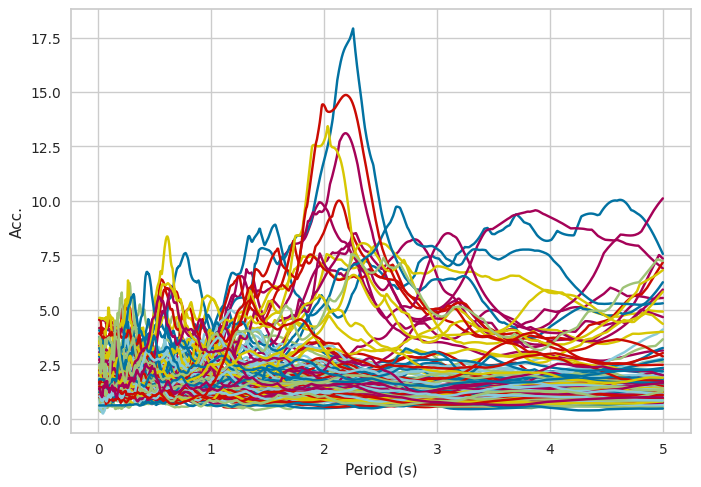

In [ ]:
plt.plot(df_psa_merged['period'].values, df_merge_spectral_coefs_mean.values)
plt.xlabel('Period (s)')
plt.ylabel('Acc.')
plt.show()


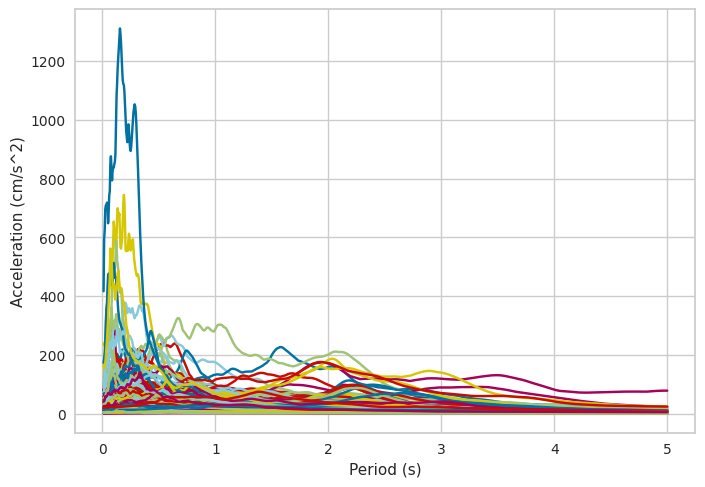

In [ ]:
plt.plot(df_psa_merged['period'].values, df_merge_spectral_mean.values)

#df_merge_spectral_mean.plot(legend=False)
plt.xlabel('Period (s)')
plt.ylabel('Acceleration (cm/s^2)')
plt.show()

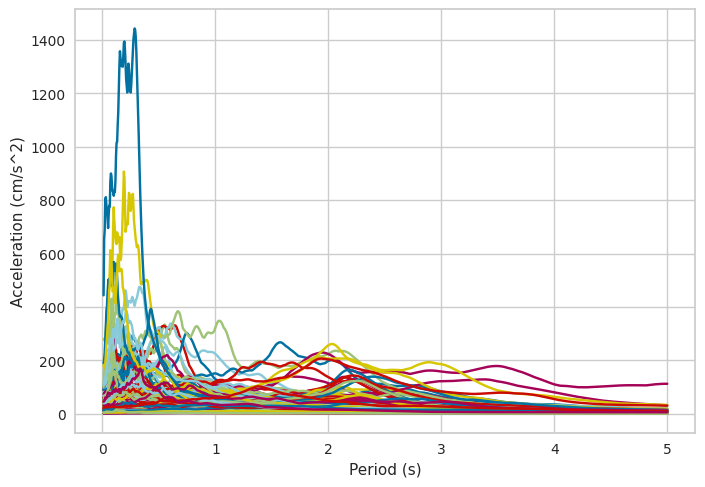

In [ ]:
plt.plot(df_psa_merged['period'].values, df_merge_horiz_spectral_mean.values)


#df_merge_horiz_spectral_mean.plot(legend=False)
plt.xlabel('Period (s)')
plt.ylabel('Acceleration (cm/s^2)')
plt.show()

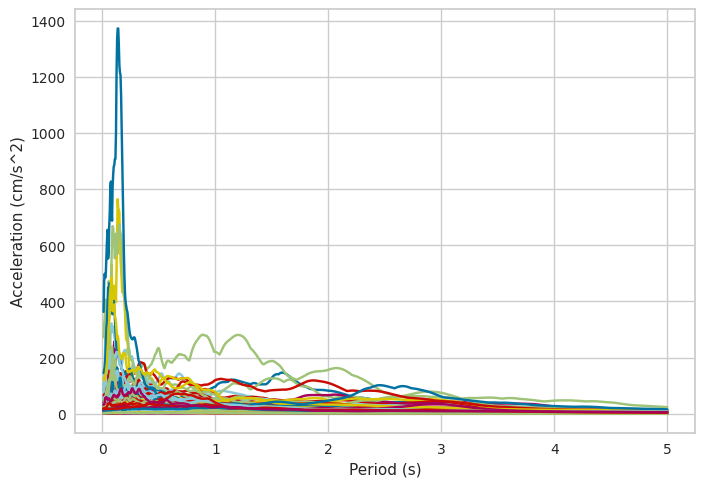

In [ ]:
plt.plot(df_psa_merged['period'].values, df_merge_vertical_spectral_mean.values)

#df_merge_vertical_spectral_mean.plot(legend=False)
plt.xlabel('Period (s)')
plt.ylabel('Acceleration (cm/s^2)')
plt.show()

Text(0.5, 1.0, '(d)')

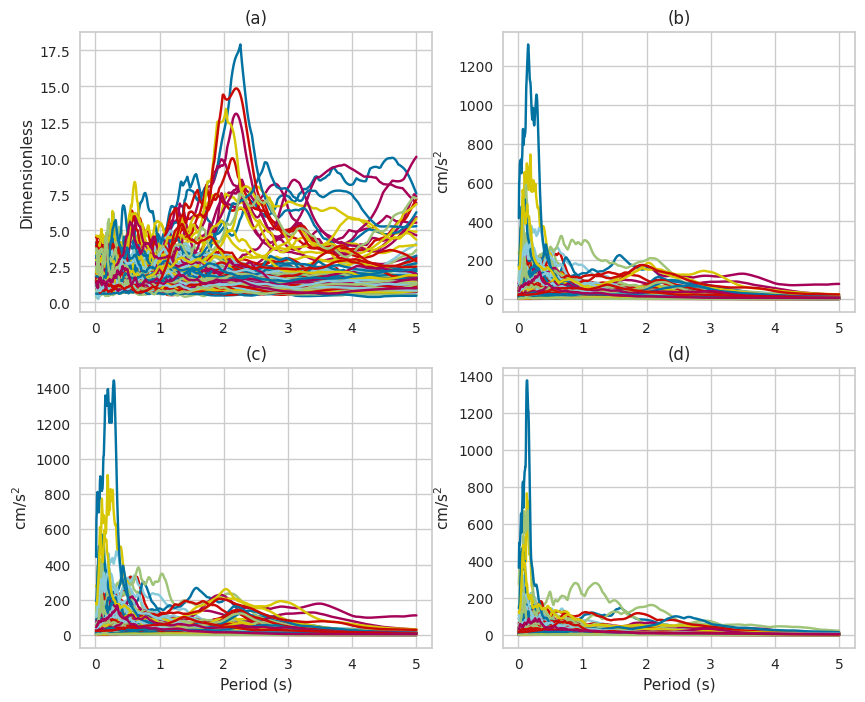

In [ ]:
#Figure: a) Spectral Ratio, b) Three Axis Spectra c) Horizontal Spectral d) Vertical Spectra

fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[0,0].plot(df_psa_merged['period'].values, df_merge_spectral_coefs_mean.values)
#axs[0,0].set_xlabel('Period (s)')
axs[0,0].set_ylabel('Dimensionless')
axs[0,0].set_title('(a)')
#axs[0,0].show()

axs[0,1].plot(df_psa_merged['period'].values, df_merge_spectral_mean.values)
#axs[0,1].set_xlabel('Period (s)')
axs[0,1].set_ylabel('cm/s$^2$')
axs[0,1].set_title('(b)')

axs[1, 0].plot(df_psa_merged['period'].values, df_merge_horiz_spectral_mean.values)
axs[1, 0].set_xlabel('Period (s)')
axs[1, 0].set_ylabel('cm/s$^2$')
axs[1, 0].set_title('(c)')

axs[1, 1].plot(df_psa_merged['period'].values, df_merge_vertical_spectral_mean.values)
axs[1, 1].set_xlabel('Period (s)')
axs[1, 1].set_ylabel('cm/s$^2$')
axs[1, 1].set_title('(d)')

Figure: a) Spectral Ratio, b) Three Axis Spectra c) Horizontal Spectral d) Vertical Spectra

## Clustering

In [ ]:
df.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth',
       'log_incidence_angle', 'magnitude_cat', 'peak_ground_acceleration_cat',
       'calculated_epicentral_distance_cat', 'depth_cat'],
      dtype='object')

### spectral coefs

In [ ]:
X=df_merge_spectral_coefs_mean.T.copy().values

In [ ]:
Xscaled=X.copy()

for i in range(len(X)):
    scaler = MinMaxScaler()
    Xscaled[i] = MinMaxScaler().fit_transform(X[i].reshape(-1,1)).reshape(len(X[i]))

In [ ]:
scores = []
for i in range(2, 8):
  kmeans = KMeans(n_clusters=i, random_state=42, n_init=10).fit(Xscaled)
  #ss=silhouette_score(Xscaled, kmeans.labels_)
  #print(ss)
  scores.append(kmeans.inertia_)

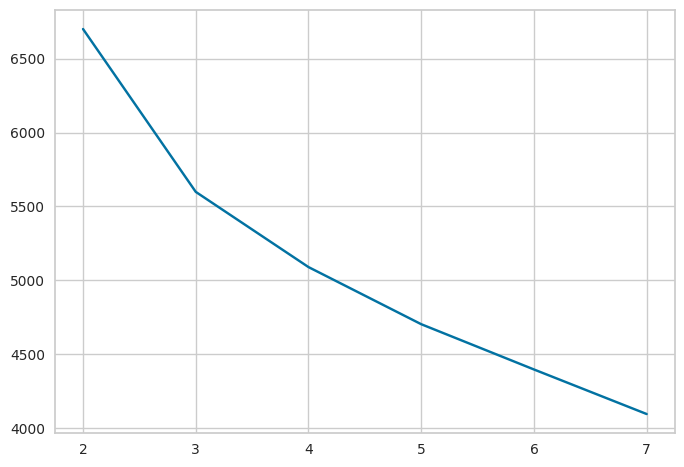

In [ ]:
plt.plot(range(2,8), scores)

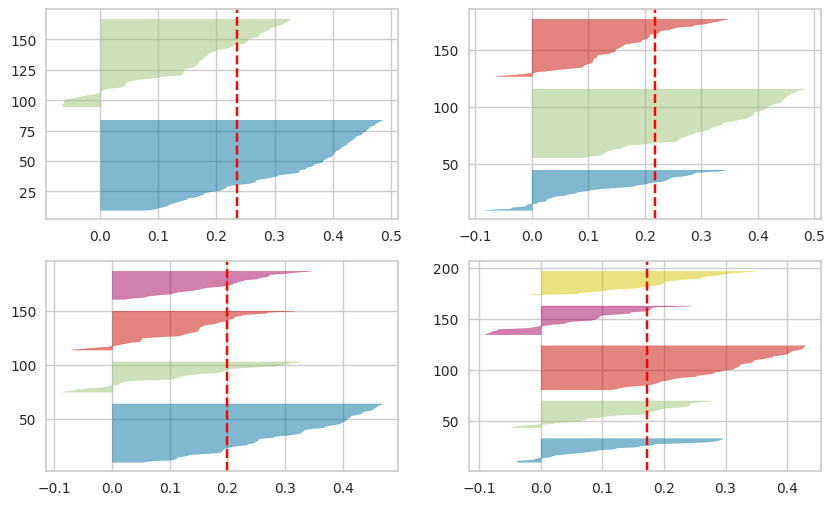

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(Xscaled)

In [ ]:
k=4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(Xscaled)

In [ ]:
labels_kmeans_spectral_coefs_mean = kmeans.labels_

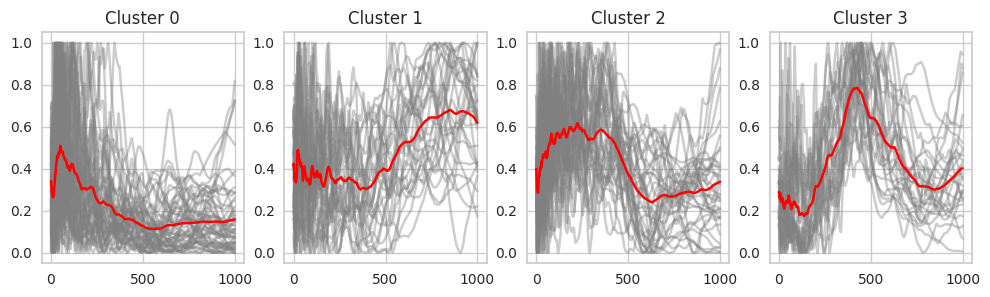

In [ ]:
fig, axs = plt.subplots(1, k, figsize=(12,3))
#fig.suptitle('Clusters')
row_i=0
column_j=0

# For each label there is,
# plots every series with that label
for label in set(labels_kmeans_spectral_coefs_mean):
    cluster = []
    for i in range(len(labels_kmeans_spectral_coefs_mean)):
      if(labels_kmeans_spectral_coefs_mean[i]==label):
          axs[column_j].plot(Xscaled[i], c="gray", alpha=0.4)
          cluster.append(Xscaled[i])
    if len(cluster) > 0:
        axs[column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[column_j].set_title("Cluster "+str(label))
    column_j+=1



plt.show()

In [ ]:
clusters_kmeans_spectral_coefs_mean_dict = dict(zip(station_keys_set, labels_kmeans_spectral_coefs_mean))

### spectral mean

In [ ]:
X=df_merge_spectral_mean.T.copy().values

In [ ]:
Xscaled=X.copy()

for i in range(len(X)):
    scaler = MinMaxScaler()
    Xscaled[i] = MinMaxScaler().fit_transform(X[i].reshape(-1,1)).reshape(len(X[i]))

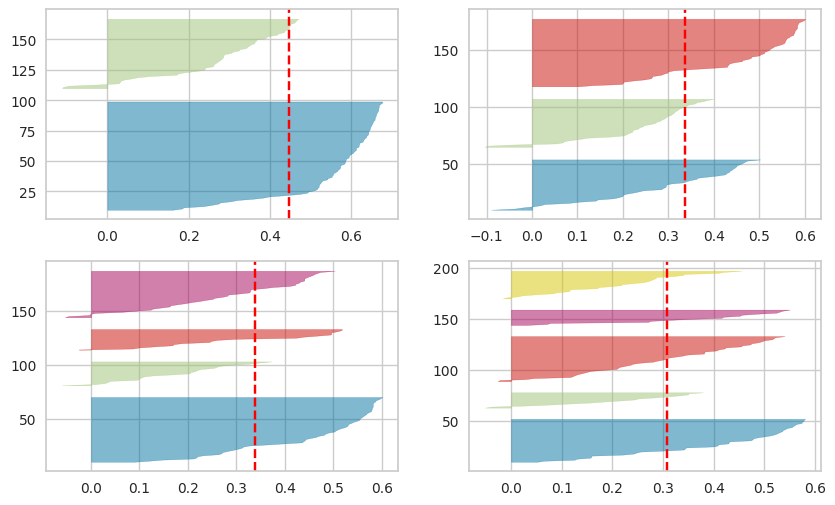

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(Xscaled)

In [ ]:
k=4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(Xscaled)

In [ ]:
labels_kmeans_spectral_mean = kmeans.labels_

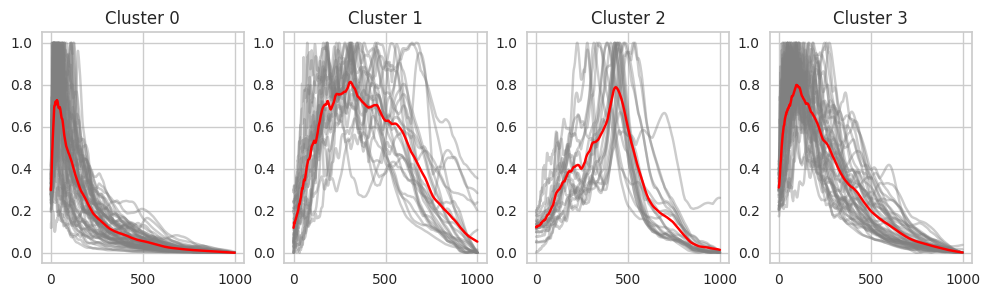

In [ ]:
fig, axs = plt.subplots(1, k, figsize=(12,3))
#fig.suptitle('Clusters')
row_i=0
column_j=0

# For each label there is,
# plots every series with that label
for label in set(labels_kmeans_spectral_mean):
    cluster = []
    for i in range(len(labels_kmeans_spectral_mean)):
      if(labels_kmeans_spectral_mean[i]==label):
          axs[column_j].plot(Xscaled[i], c="gray", alpha=0.4)
          cluster.append(Xscaled[i])
    if len(cluster) > 0:
        axs[column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[column_j].set_title("Cluster "+str(label))
    column_j+=1



plt.show()

In [ ]:
clusters_kmeans_spectral_mean_dict = dict(zip(station_keys_set, labels_kmeans_spectral_mean))

### spectral horizontal mean

In [ ]:
X=df_merge_horiz_spectral_mean.T.copy().values

In [ ]:
Xscaled=X.copy()

for i in range(len(X)):
    scaler = MinMaxScaler()
    Xscaled[i] = MinMaxScaler().fit_transform(X[i].reshape(-1,1)).reshape(len(X[i]))

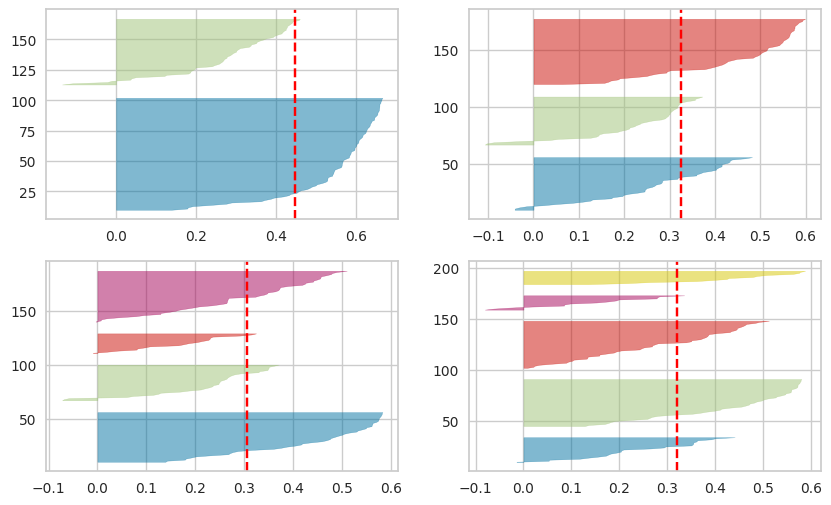

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(Xscaled)

In [ ]:
k=4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(Xscaled)

In [ ]:
labels_kmeans_spectral_horiz_mean = kmeans.labels_

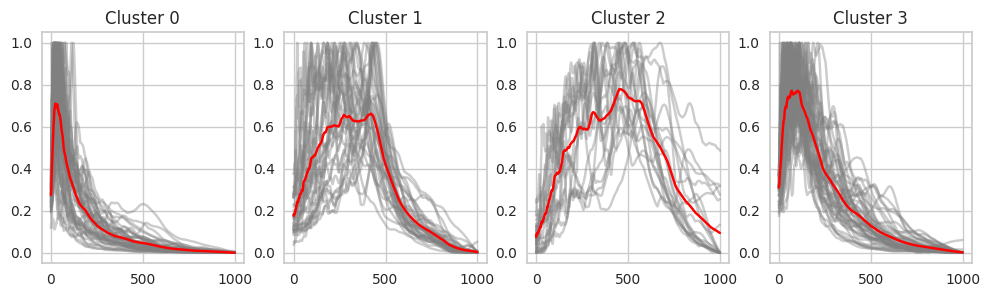

In [ ]:
fig, axs = plt.subplots(1, k, figsize=(12,3))
#fig.suptitle('Clusters')
row_i=0
column_j=0

# For each label there is,
# plots every series with that label
for label in set(labels_kmeans_spectral_horiz_mean):
    cluster = []
    for i in range(len(labels_kmeans_spectral_horiz_mean)):
      if(labels_kmeans_spectral_horiz_mean[i]==label):
          axs[column_j].plot(Xscaled[i], c="gray", alpha=0.4)
          cluster.append(Xscaled[i])
    if len(cluster) > 0:
        axs[column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[column_j].set_title("Cluster "+str(label))
    column_j+=1



plt.show()

In [ ]:
clusters_kmeans_spectral_horiz_mean_dict = dict(zip(station_keys_set, labels_kmeans_spectral_horiz_mean))

### spectral vertical mean

In [ ]:
X=df_merge_vertical_spectral_mean.T.copy().values

In [ ]:
Xscaled=X.copy()

for i in range(len(X)):
    scaler = MinMaxScaler()
    Xscaled[i] = MinMaxScaler().fit_transform(X[i].reshape(-1,1)).reshape(len(X[i]))

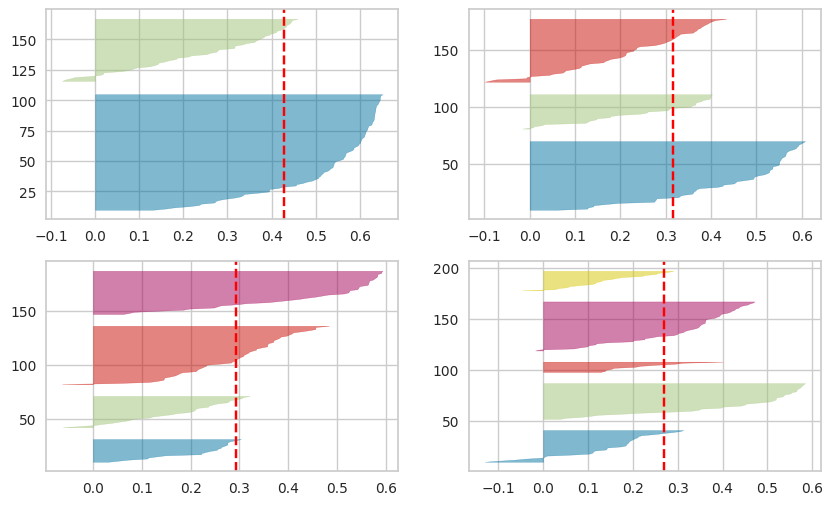

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(Xscaled)

In [ ]:
k=4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(Xscaled)

In [ ]:
labels_kmeans_spectral_vert_mean = kmeans.labels_

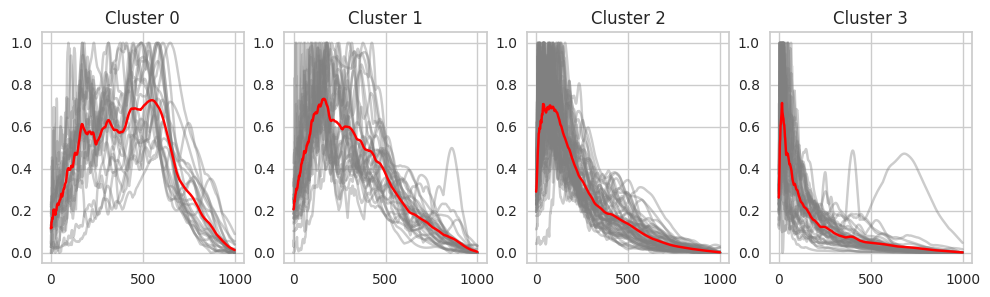

In [ ]:
fig, axs = plt.subplots(1, k, figsize=(12,3))
#fig.suptitle('Clusters')
row_i=0
column_j=0

# For each label there is,
# plots every series with that label
for label in set(labels_kmeans_spectral_vert_mean):
    cluster = []
    for i in range(len(labels_kmeans_spectral_vert_mean)):
      if(labels_kmeans_spectral_vert_mean[i]==label):
          axs[column_j].plot(Xscaled[i], c="gray", alpha=0.4)
          cluster.append(Xscaled[i])
    if len(cluster) > 0:
        axs[column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[column_j].set_title("Cluster "+str(label))
    column_j+=1



plt.show()

In [ ]:
clusters_kmeans_spectral_vert_mean_dict = dict(zip(station_keys_set, labels_kmeans_spectral_vert_mean))

## Add cluster column

In [ ]:
df.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth',
       'log_incidence_angle', 'magnitude_cat', 'peak_ground_acceleration_cat',
       'calculated_epicentral_distance_cat', 'depth_cat'],
      dtype='object')

In [ ]:
def add_clusters(df, clusters_dict, cluster_column_name):
  lost_stations = []
  df_com_clusters = df.copy()

  for index, row in df_com_clusters.iterrows():
    #print(index)
    station_key = df_com_clusters['station_key'].iloc[index]
    #print(station_key)
    try:
      df_com_clusters.at[index, cluster_column_name] = clusters_dict[station_key]
    except:
      #print(f'station key not found: {station_key}')
      lost_stations.append(station_key)
  return df_com_clusters, lost_stations

In [ ]:
df_com_clusters, lost_stations = add_clusters(df, clusters_kmeans_spectral_coefs_mean_dict, 'clusters_spectral_coefs')

In [ ]:
df_com_clusters, lost_stations = add_clusters(df_com_clusters, clusters_kmeans_spectral_mean_dict, 'clusters_spectral_means')

In [ ]:
df_com_clusters, lost_stations = add_clusters(df_com_clusters, clusters_kmeans_spectral_horiz_mean_dict, 'clusters_spectral_horiz_means')

In [ ]:
df_com_clusters, lost_stations = add_clusters(df_com_clusters, clusters_kmeans_spectral_vert_mean_dict, 'clusters_spectral_vert_means')

In [ ]:
df_com_clusters.clusters_spectral_means.value_counts()

0.0    732
3.0    576
1.0    194
2.0    110
Name: clusters_spectral_means, dtype: int64

##Split

In [ ]:
#train_set, test_set = train_test_split(df_com_clusters, test_size=0.20, random_state=42)

In [ ]:
df_com_clusters.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth',
       'log_incidence_angle', 'magnitude_cat', 'peak_ground_acceleration_cat',
       'calculated_epicentral_distance_cat', 'depth_cat',
       'clusters_spectral_coefs', 'clusters_spectral_means',
       'clusters_spectral_horiz_means', 'clusters_spectral_vert_means'],
      dtype='object')

In [ ]:
strat_column="magnitude_cat"

In [ ]:
df_com_clusters.shape

(1612, 37)

In [ ]:
train_set, test_set = train_test_split(
df_com_clusters, test_size=0.2, stratify=df_com_clusters[strat_column], random_state=42)

In [ ]:
train_set.shape

(1289, 37)

In [ ]:
test_set.shape

(323, 37)

In [ ]:
test_set[strat_column].value_counts() / len(test_set)

3    0.275542
2    0.256966
1    0.253870
4    0.213622
Name: magnitude_cat, dtype: float64

In [ ]:
train_set.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth',
       'log_incidence_angle', 'magnitude_cat', 'peak_ground_acceleration_cat',
       'calculated_epicentral_distance_cat', 'depth_cat',
       'clusters_spectral_coefs', 'clusters_spectral_means',
       'clusters_spectral_horiz_means', 'clusters_spectral_vert_means'],
      dtype='object')

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_set, train_set.peak_ground_acceleration, test_size=0.2, random_state=42, stratify=train_set[strat_column]) #for DNN


# Machine Learning Regression Training

## hiperparameters tuning

In [ ]:
"""
num_attributes = ['magnitude',
             'calculated_epicentral_distance', 'depth', 'calculated_incidence_angle',
             'calculated_hypocentral_distance', 'calculated_azimuth', 'source_off_shore', 'log_incidence_angle']
"""

num_attributes = ['magnitude',
             'calculated_epicentral_distance', 'depth', 'calculated_incidence_angle',
             'calculated_hypocentral_distance', 'calculated_azimuth', 'source_off_shore', 'log_incidence_angle']

num_pipeline = Pipeline([
  ("standardize", StandardScaler()),
])

In [ ]:

cat_attribs = [selected_cluster_column]


cat_pipeline = make_pipeline(
  SimpleImputer(strategy="most_frequent"),
  OneHotEncoder(handle_unknown="ignore"))


preprocessor = ColumnTransformer([
  ("cat", cat_pipeline, cat_attribs),
  ('num', num_pipeline, num_attributes)
  ], remainder="drop")

In [ ]:
selected_cluster_column = 'clusters_spectral_means'


### Random Forest Grid Search

In [ ]:
steps = [
    ('preprocessor', preprocessor),
    #('poly', PolynomialFeatures(degree=2)),
    #('model', LinearRegression())
    ('model', RandomForestRegressor(random_state=42))
    #('model', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000))
]

pipeline = Pipeline(steps)

In [ ]:
param_grid = [
    {'model__n_estimators': [300, 500, 700, 900, 1200, 1500, 1800, 2100],
     'model__max_features': [0.3, 0.2, 0.1],
     #'model__max_features': [1, 2, 3],
     #'model__min_samples_leaf': [1, 3, 5],
     #'model__warm_start' : [True, False],
     #'model__max_depth': [None, 5, 10, 15], #testes mostraram que none é melhor
     #'model__max_samples': [1.0, 0.5, 0.3] #testes mostraram que 1.0 é melhor
     #'model__oob_score': [True, False]
     #'model__oob_score': [True]
  }]

#forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=False,
                           verbose=3)


In [ ]:
grid_search.fit(train_set, train_set['peak_ground_acceleration'])

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END model__max_features=0.3, model__n_estimators=300;, score=-1377.240 total time=   2.1s
[CV 2/5] END model__max_features=0.3, model__n_estimators=300;, score=-1754.825 total time=   0.9s
[CV 3/5] END model__max_features=0.3, model__n_estimators=300;, score=-1934.363 total time=   0.9s
[CV 4/5] END model__max_features=0.3, model__n_estimators=300;, score=-1047.056 total time=   1.4s
[CV 5/5] END model__max_features=0.3, model__n_estimators=300;, score=-2491.213 total time=   1.4s
[CV 1/5] END model__max_features=0.3, model__n_estimators=500;, score=-1381.068 total time=   2.1s
[CV 2/5] END model__max_features=0.3, model__n_estimators=500;, score=-1767.204 total time=   1.5s
[CV 3/5] END model__max_features=0.3, model__n_estimators=500;, score=-1930.854 total time=   1.5s
[CV 4/5] END model__max_features=0.3, model__n_estimators=500;, score=-1060.121 total time=   1.5s
[CV 5/5] END model__max_features=0.3, model__n_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['clusters_spectral_means']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['magnitude',
                                                                          'calculated_epicen...tance',
                                                                          'depth',
                                                                          'calculated_incidence_angle',
                                                                          'calculated_hypocentral_distance',
                                                                          'calculated_azimuth',
                                                                          'source_off_shore',
                                                                          'log_incidence_angle'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'model__max_features': [0.3, 0.2, 0.1],
                          'model__n_estimators': [300, 500, 700, 900, 1200,
                                                  1500, 1800, 2100]}],
             scoring='neg_mean_squared_error', verbose=3)

In [ ]:
grid_search.best_params_

{'model__max_features': 0.1, 'model__n_estimators': 1500}

In [ ]:
np.sqrt(-grid_search.best_score_)

40.27468880667747

In [ ]:
best_grid = grid_search.best_estimator_

In [ ]:
#best_grid.get_params('model')

In [ ]:
pred = best_grid.predict(test_set)
rmse = mean_squared_error(test_set['peak_ground_acceleration'], pred, squared=False)
rmse

30.96972034098288

In [ ]:
best_grid['model'].feature_importances_

array([0.01128274, 0.00488959, 0.01995519, 0.00163207, 0.08964829,
       0.19738878, 0.07015551, 0.15312963, 0.20491495, 0.08598323,
       0.01421165, 0.14680837])

In [ ]:
num_attributes

['magnitude',
 'calculated_epicentral_distance',
 'depth',
 'calculated_incidence_angle',
 'calculated_hypocentral_distance',
 'calculated_azimuth',
 'source_off_shore',
 'log_incidence_angle']

### neural network grid search

In [ ]:
selected_cluster_column = 'clusters_spectral_means'

cat_attribs = [selected_cluster_column]


cat_pipeline = make_pipeline(
  SimpleImputer(strategy="most_frequent"),
  OneHotEncoder(handle_unknown="ignore"))


preprocessor = ColumnTransformer([
  ("cat", cat_pipeline, cat_attribs),
  ('num', num_pipeline, num_attributes)
  ], remainder="drop")

#### keras turner

In [ ]:
def build_model(hp):
  n_hidden = hp.Int("n_hidden", min_value=2, max_value=11, default=2)
  n_neurons = hp.Int("n_neurons", min_value=100, max_value=1800)
  learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                           sampling="log")
  #optimizer = hp.Choice("optimizer", values=["sgd", "adam", 'adamw', 'nesterov'])
  optimizer = hp.Choice("optimizer", values=["adam", 'nesterov'])
  activation_function = hp.Choice("activation", values=["relu", "swish"])

  if optimizer == "sgd":
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer == "nesterov":
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, nesterov=True, momentum=0.9)
  elif optimizer == "adamw":
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
  else:drop
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten())

  for _ in range(n_hidden):
    model.add(tf.keras.layers.Dense(n_neurons, activation=activation_function, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())

  #model.add(tf.keras.layers.Dense(10, activation="softmax"))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss="huber",  #loss="mse",
                optimizer=optimizer,
                metrics=["RootMeanSquaredError"])
  return model

In [ ]:
"""
selected_cluster_column = 'clusters_spectral_means'

cat_attribs = [selected_cluster_column]


cat_pipeline = make_pipeline(
  SimpleImputer(strategy="most_frequent"),
  OneHotEncoder(handle_unknown="ignore"))


preprocessor = ColumnTransformer([
  ("cat", cat_pipeline, cat_attribs),
  ('num', num_pipeline, num_attributes)
  ], remainder="drop")
"""

'\nselected_cluster_column = \'clusters_spectral_means\'\n\ncat_attribs = [selected_cluster_column]\n\n\ncat_pipeline = make_pipeline(\n  SimpleImputer(strategy="most_frequent"),\n  OneHotEncoder(handle_unknown="ignore"))\n\n\npreprocessor = ColumnTransformer([\n  ("cat", cat_pipeline, cat_attribs),\n  (\'num\', num_pipeline, num_attributes)\n  ], remainder="drop")\n'

In [ ]:
tf_x_train = preprocessor.fit_transform(X_train)
tf_x_valid = preprocessor.transform(X_valid)

In [ ]:
#tf_train = preprocessor.fit_transform(train_set)

In [ ]:
#X_train, X_valid, y_train, y_valid = train_test_split(tf_train, train_set.peak_ground_acceleration, test_size=0.2, random_state=42)

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_root_mean_squared_error", direction="min"),
                     max_epochs=50,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt',
                     seed=42,
                     overwrite=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


In [ ]:
tuner.search(tf_x_train, y_train, validation_data=(tf_x_valid, y_valid), callbacks=[stop_early], verbose=2)



Trial 90 Complete [00h 01m 26s]
val_root_mean_squared_error: 40.12408447265625

Best val_root_mean_squared_error So Far: 40.12408447265625
Total elapsed time: 00h 28m 28s


In [ ]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 0089 summary
Hyperparameters:
n_hidden: 5
n_neurons: 1583
learning_rate: 0.0006601146406744397
optimizer: nesterov
activation: swish
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 40.12408447265625


Trial 0081 summary
Hyperparameters:
n_hidden: 10
n_neurons: 687
learning_rate: 0.0015141913494764387
optimizer: nesterov
activation: relu
tuner/epochs: 17
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 39.60440444946289

In [ ]:
random_search_tuner = kt.RandomSearch(
    build_model, objective=kt.Objective("val_root_mean_squared_error", direction="min"), max_trials=200, overwrite=True,
    directory="nn_model", project_name="my_rnd_search", seed=42)

random_search_tuner.search(tf_x_train, y_train, epochs=10,
                           validation_data=(tf_x_valid, y_valid), verbose=2)

Trial 13 Complete [00h 00m 07s]
val_root_mean_squared_error: 42.55516052246094

Best val_root_mean_squared_error So Far: 42.25779724121094
Total elapsed time: 00h 02m 45s

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
5                 |4                 |n_hidden
204               |497               |n_neurons
0.00036238        |0.0029044         |learning_rate
nesterov          |adam              |optimizer
swish             |swish             |activation

Epoch 1/10


KeyboardInterrupt: ignored

In [ ]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

In [ ]:
best_model = random_search_tuner.get_best_models(num_models=1)[0]

In [ ]:
es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=2, patience=10)
mcp_save = ModelCheckpoint('.mdl_nn.hdf5', save_best_only=True, monitor='val_root_mean_squared_error', mode='min')

history = best_model.fit(tf_x_train, y_train, epochs=50, callbacks=[es, mcp_save], validation_data=(tf_x_valid, y_valid))
#test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/50
33/33 [==============================] - 4s 30ms/step - loss: 16.6511 - root_mean_squared_error: 45.4705 - val_loss: 17.5875 - val_root_mean_squared_error: 42.7118
Epoch 2/50
33/33 [==============================] - 1s 19ms/step - loss: 17.1761 - root_mean_squared_error: 45.8750 - val_loss: 16.5886 - val_root_mean_squared_error: 43.7266
Epoch 3/50
33/33 [==============================] - 1s 19ms/step - loss: 15.6213 - root_mean_squared_error: 43.1355 - val_loss: 15.6251 - val_root_mean_squared_error: 45.2149
Epoch 4/50
33/33 [==============================] - 1s 19ms/step - loss: 16.4061 - root_mean_squared_error: 43.3024 - val_loss: 14.8706 - val_root_mean_squared_error: 43.6531
Epoch 5/50
33/33 [==============================] - 1s 19ms/step - loss: 15.5658 - root_mean_squared_error: 43.8997 - val_loss: 15.4163 - val_root_mean_squared_error: 43.4509
Epoch 6/50
33/33 [==============================] - 1s 18ms/step - loss: 15.9410 - root_mean_squared_error: 41.9034 - val_los

In [ ]:
best_model = load_model('.mdl_nn.hdf5')

In [ ]:
test_loss, test_accuracy = best_model.evaluate(tf_x_valid, y_valid)
print(test_accuracy)

9/9 [==============================] - 0s 6ms/step - loss: 17.5875 - root_mean_squared_error: 42.7118
42.711822509765625


In [ ]:
tf_test = preprocessor.transform(test_set)

test_loss, test_accuracy = best_model.evaluate(tf_test, test_set['peak_ground_acceleration'])
print(test_accuracy)

11/11 [==============================] - 0s 6ms/step - loss: 19.3334 - root_mean_squared_error: 43.6645
43.664493560791016


In [ ]:
tf_test = preprocessor.transform(test_set)
predictions = best_model.predict(tf_test)
test_rmse = mean_squared_error(test_set['peak_ground_acceleration'], predictions, squared=False)
print(test_rmse)

11/11 [==============================] - 0s 6ms/step
43.66448825868051


## experiments

In [ ]:
num_attributes = ['magnitude',
             'calculated_epicentral_distance', 'depth', 'calculated_incidence_angle',
             'calculated_hypocentral_distance', 'calculated_azimuth', 'source_off_shore', 'log_incidence_angle']

num_pipeline = Pipeline([
  ("standardize", StandardScaler()),
])

In [ ]:
def model_experiment(train_set, test_set, pipeline, experiments_dict, experiment_name):

  pipeline.fit(train_set, train_set['peak_ground_acceleration'])

  #pred = pipeline.predict(test_set)

  #rmse = mean_squared_error(train_set['peak_ground_acceleration'], pred, squared=False)

  predictions = pipeline.predict(test_set)
  test_rmse = mean_squared_error(test_set['peak_ground_acceleration'], predictions, squared=False)
  r2 = r2_score(test_set['peak_ground_acceleration'], predictions)

  confidence = 0.95
  squared_errors = (predictions - test_set['peak_ground_acceleration']) ** 2
  conf_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                           loc=squared_errors.mean(),
                           scale=stats.sem(squared_errors)))
  conf_range = conf_interval[1] - conf_interval[0]

  experiments_dict[experiment_name] = [test_rmse, r2, conf_interval[0], conf_interval[1]]
  #experiments_list[experiment_name] = [test_rmse, r2, conf_range]

  #errors = (predictions - test_set['peak_ground_acceleration'])

  #scores = -cross_val_score(pipeline, train_set, train_set['peak_ground_acceleration'], cv=5, scoring='neg_root_mean_squared_error')

  return test_rmse, r2, pipeline, experiments_dict

In [ ]:
experiments = {}
trained_pipelines = {}

RF_max_features=0.1
RF_n_estimators= 900
RF_oob_score=False
RF_warm_start=False

nn_neurons = 1583 #534#687
nn_hidden_layers = 5 #7
nn_activation = "swish" #"relu"
nn_learning_rate = 0.0006601146406744397 #0.00256

"""
last hiperband
n_hidden: 5
n_neurons: 1583
learning_rate: 0.0006601146406744397
activation: swish
"""

elasticnet_alpha=0.1
elasticnet_l1_ratio=0.5
elasticnet_max_iter=100000

polynomial_include_bias=True

nn_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=nn_learning_rate, nesterov=True, momentum=0.9)



# for dnn
X_train, X_valid, y_train, y_valid = train_test_split(train_set, train_set.peak_ground_acceleration, test_size=0.2, random_state=42, stratify=train_set[strat_column])

preprocessor = ColumnTransformer([
  ('num', num_pipeline, num_attributes)
  ], remainder="drop")


In [ ]:
num_attributes

['magnitude',
 'calculated_epicentral_distance',
 'depth',
 'calculated_incidence_angle',
 'calculated_hypocentral_distance',
 'calculated_azimuth',
 'source_off_shore',
 'log_incidence_angle']

### without clusters

In [ ]:
train_set.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth',
       'log_incidence_angle', 'magnitude_cat', 'peak_ground_acceleration_cat',
       'calculated_epicentral_distance_cat', 'depth_cat',
       'clusters_spectral_coefs', 'clusters_spectral_means',
       'clusters_spectral_horiz_means', 'clusters_spectral_vert_means'],
      dtype='object')

In [ ]:
steps = [
    ('preprocessor', preprocessor),
    #('poly', PolynomialFeatures(degree=3)),
    ('model', LinearRegression())
    #('model', RandomForestRegressor(random_state=42))
    #('model', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000))
]

pipeline = Pipeline(steps)

#pipeline.fit(train_set, train_set['peak_ground_acceleration'])

#cros_val_error_mean, cros_val_error_std, pipeline = model_experiment(train_set, pipeline)
#predictions = pipeline.predict(test_set)
#test_rmse = mean_squared_error(test_set['peak_ground_acceleration'], predictions, squared=False)
model_name = 'Linear Regression'

test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)

trained_pipelines[model_name] = pipeline

#experiments['Linear Regression'] = [test_rmse, r2]

experiments

{'Linear Regression': [46.41142246148078,
  0.46098495919870697,
  34.96560657627764,
  55.54679672626546]}

In [ ]:
steps = [
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=polynomial_include_bias)),
    ('model', LinearRegression())
    #('model', RandomForestRegressor(random_state=42))
    #('model', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000))
]

pipeline = Pipeline(steps)

#pipeline.fit(train_set, train_set['peak_ground_acceleration'])
model_name = 'Polynomial Regression'
test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)

trained_pipelines[model_name] = pipeline

#experiments['Polynomial Regression'] = [test_rmse, r2]

experiments

{'Linear Regression': [46.41142246148078,
  0.46098495919870697,
  34.96560657627764,
  55.54679672626546],
 'Polynomial Regression': [40.32114265999177,
  0.5931664244778411,
  29.41341620077867,
  48.851203037536216]}

In [ ]:
len(trained_pipelines)

2

In [ ]:
steps = [
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=polynomial_include_bias)),
    #('model', LinearRegression())
    #('model', RandomForestRegressor(random_state=42))
    ('model', ElasticNet(alpha=elasticnet_alpha, l1_ratio=elasticnet_l1_ratio, max_iter=elasticnet_max_iter))
]

pipeline = Pipeline(steps)

#pipeline.fit(train_set, train_set['peak_ground_acceleration'])
model_name = 'Polynomial ElasticNet'
test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)

trained_pipelines[model_name] = pipeline

#experiments['Polynomial ElasticNet'] = [test_rmse, r2]

experiments

{'Linear Regression': [46.41142246148078,
  0.46098495919870697,
  34.96560657627764,
  55.54679672626546],
 'Polynomial Regression': [40.32114265999177,
  0.5931664244778411,
  29.41341620077867,
  48.851203037536216],
 'Polynomial ElasticNet': [41.99380680736759,
  0.5587125085632203,
  31.226815960310937,
  50.5157954043079]}

In [ ]:
steps = [
    ('preprocessor', preprocessor),
    #('poly', PolynomialFeatures(degree=2)),
    #('model', LinearRegression())
    ('model', RandomForestRegressor(max_features=RF_max_features, n_estimators=RF_n_estimators, oob_score=RF_oob_score, warm_start=RF_warm_start, random_state=42))
    #('model', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000))
]

pipeline = Pipeline(steps)

#pipeline.fit(train_set, train_set['peak_ground_acceleration'])
model_name = 'Random Forest'
test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)

trained_pipelines[model_name] =pipeline

#experiments['Random Forest'] = [test_rmse, r2]

experiments

{'Linear Regression': [46.41142246148078,
  0.46098495919870697,
  34.96560657627764,
  55.54679672626546],
 'Polynomial Regression': [40.32114265999177,
  0.5931664244778411,
  29.41341620077867,
  48.851203037536216],
 'Polynomial ElasticNet': [41.99380680736759,
  0.5587125085632203,
  31.226815960310937,
  50.5157954043079],
 'Random Forest': [34.82428952699403,
  0.6965300765350808,
  26.60187530556498,
  41.446381173113096]}

In [ ]:
pipeline['model'].feature_importances_

array([0.08961544, 0.21287568, 0.07116152, 0.15245266, 0.21233577,
       0.09079394, 0.01441758, 0.15634742])

In [ ]:
num_attributes

['magnitude',
 'calculated_epicentral_distance',
 'depth',
 'calculated_incidence_angle',
 'calculated_hypocentral_distance',
 'calculated_azimuth',
 'source_off_shore',
 'log_incidence_angle']

In [ ]:
test_set.shape

(323, 37)

In [ ]:

#nn_neurons=900

model = tf.keras.Sequential()

for _ in range(nn_hidden_layers):
    model.add(tf.keras.layers.Dense(nn_neurons, activation=nn_activation, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(loss="huber",  #loss="mse",
              optimizer=nn_optimizer,
              metrics=["RootMeanSquaredError"])


#mcp_save = ModelCheckpoint('mdl_nn.hdf5', save_best_only=True, monitor='val_root_mean_squared_error', mode='min')
mcp_save = ModelCheckpoint(filepath='.', save_best_only=True, monitor='val_root_mean_squared_error', mode='min', save_weights_only=True)
es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=2, patience=10)

#tf_train = preprocessor.fit_transform(train_set)


tf_x_train = preprocessor.fit_transform(X_train)
tf_x_valid = preprocessor.transform(X_valid)

history = model.fit(tf_x_train, y_train, epochs=50, callbacks=[es, mcp_save], validation_data=(tf_x_valid, y_valid))
model.load_weights('.')
#best_model = load_model('mdl_nn.hdf5')

tf_test = preprocessor.transform(test_set)
predictions = model.predict(tf_test)

test_rmse = mean_squared_error(test_set['peak_ground_acceleration'], predictions, squared=False)
r2 = r2_score(test_set['peak_ground_acceleration'], predictions)

confidence = 0.95
squared_errors = (predictions[:, 0] - test_set['peak_ground_acceleration']) ** 2
conf_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                          loc=squared_errors.mean(),
                          scale=stats.sem(squared_errors)))
conf_range = conf_interval[1] - conf_interval[0]

model_name = 'Deep Neural Network'
experiments[model_name] = [test_rmse, r2, conf_interval[0], conf_interval[1]]

steps = [
    ('preprocessor', preprocessor),
    ('model', model)
  ]

pipeline = Pipeline(steps)
trained_pipelines[model_name] =pipeline

experiments

Epoch 1/50
33/33 [==============================] - 10s 229ms/step - loss: 28.8527 - root_mean_squared_error: 67.0513 - val_loss: 24.7068 - val_root_mean_squared_error: 65.6602
Epoch 2/50
33/33 [==============================] - 4s 120ms/step - loss: 28.2443 - root_mean_squared_error: 66.2871 - val_loss: 24.0713 - val_root_mean_squared_error: 65.2621
Epoch 3/50
33/33 [==============================] - 4s 117ms/step - loss: 27.5316 - root_mean_squared_error: 65.4138 - val_loss: 23.3490 - val_root_mean_squared_error: 64.7518
Epoch 4/50
33/33 [==============================] - 5s 161ms/step - loss: 26.7154 - root_mean_squared_error: 64.5933 - val_loss: 22.5415 - val_root_mean_squared_error: 63.7599
Epoch 5/50
33/33 [==============================] - 4s 130ms/step - loss: 25.6632 - root_mean_squared_error: 62.5675 - val_loss: 21.5778 - val_root_mean_squared_error: 62.8811
Epoch 6/50
33/33 [==============================] - 4s 123ms/step - loss: 24.4855 - root_mean_squared_error: 61.1473 - 

{'Linear Regression': [46.41142246148078,
  0.46098495919870697,
  34.96560657627764,
  55.54679672626546],
 'Polynomial Regression': [40.32114265999177,
  0.5931664244778411,
  29.41341620077867,
  48.851203037536216],
 'Polynomial ElasticNet': [41.99380680736759,
  0.5587125085632203,
  31.226815960310937,
  50.5157954043079],
 'Random Forest': [34.82428952699403,
  0.6965300765350808,
  26.60187530556498,
  41.446381173113096],
 'Deep Neural Network': [37.86545423213687,
  0.6412123650489465,
  25.11005865303041,
  47.29767650586523]}

In [ ]:
experiments

{'Linear Regression': [46.41142246148078,
  0.46098495919870697,
  34.96560657627764,
  55.54679672626546],
 'Polynomial Regression': [40.32114265999177,
  0.5931664244778411,
  29.41341620077867,
  48.851203037536216],
 'Polynomial ElasticNet': [41.99380680736759,
  0.5587125085632203,
  31.226815960310937,
  50.5157954043079],
 'Random Forest': [34.82428952699403,
  0.6965300765350808,
  26.60187530556498,
  41.446381173113096],
 'Deep Neural Network': [37.86545423213687,
  0.6412123650489465,
  25.11005865303041,
  47.29767650586523]}

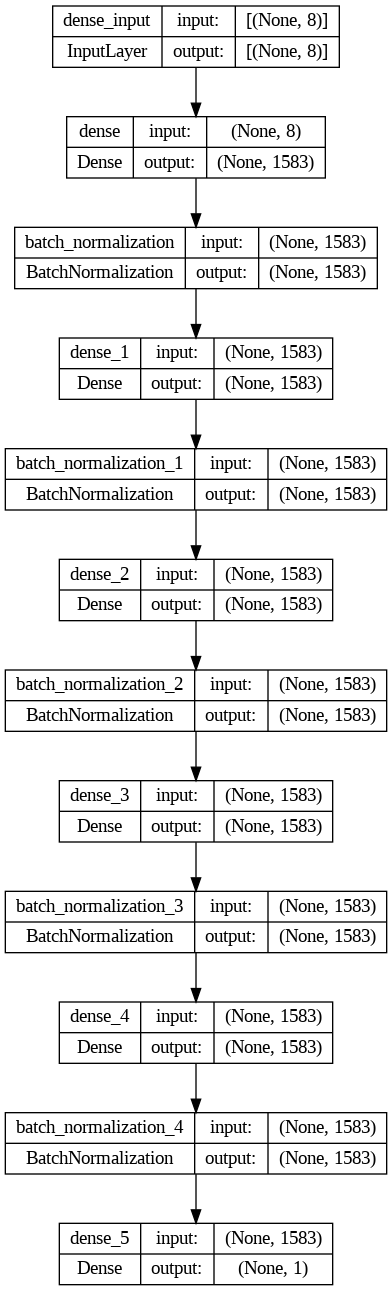

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
visualkeras.layered_view(model)

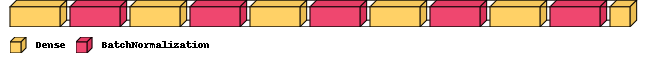

In [ ]:
visualkeras.layered_view(model, legend=True, draw_volume=True, max_z=50) # without custom font


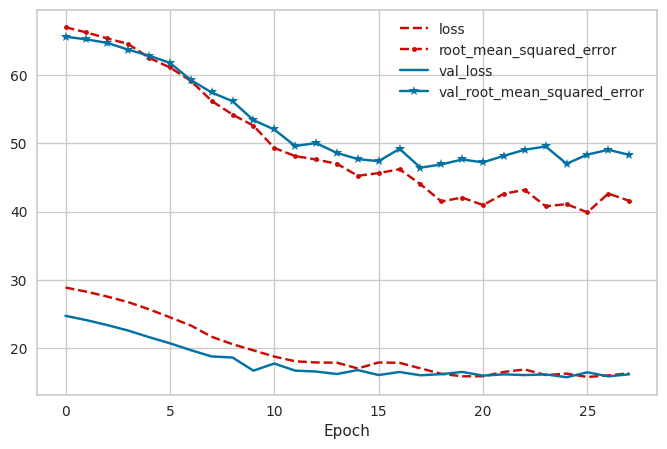

In [ ]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

### With clusters

In [ ]:
cluster_columns = ['clusters_spectral_coefs', 'clusters_spectral_means', 'clusters_spectral_horiz_means', 'clusters_spectral_vert_means']

In [ ]:
df.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth',
       'log_incidence_angle', 'magnitude_cat', 'peak_ground_acceleration_cat',
       'calculated_epicentral_distance_cat', 'depth_cat'],
      dtype='object')

In [ ]:
history_dnn = {}

In [ ]:

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

#X_train, X_valid, y_train, y_valid = train_test_split(train_set, train_set.peak_ground_acceleration, test_size=0.2, random_state=42) #for DNN

for selected_cluster_column in cluster_columns:
  print(selected_cluster_column)

  cat_attribs = [selected_cluster_column]

  preprocessor_with_psa_cluster = ColumnTransformer([
    ("cat", cat_pipeline, cat_attribs),
    ('num', num_pipeline, num_attributes)
    ], remainder="drop")


  model_name = f'Linear Regression with PSA {selected_cluster_column}'
  print(model_name)
  steps = [
    ('preprocessor', preprocessor_with_psa_cluster),
    ('model', LinearRegression())
  ]

  pipeline = Pipeline(steps)

  test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)
  trained_pipelines[model_name] = pipeline


  model_name = f'Polynomial Regression with PSA {selected_cluster_column}'
  print(model_name)

  steps = [
      ('preprocessor', preprocessor_with_psa_cluster),
      ('poly', PolynomialFeatures(degree=2, include_bias=polynomial_include_bias)),
      ('model', LinearRegression())
  ]

  pipeline = Pipeline(steps)

  test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)
  trained_pipelines[model_name] = pipeline


  model_name = f'Polynomial ElasticNet with PSA {selected_cluster_column}'
  print(model_name)

  steps = [
    ('preprocessor', preprocessor_with_psa_cluster),
    ('poly', PolynomialFeatures(degree=2, include_bias=polynomial_include_bias)),
    ('model', ElasticNet(alpha=elasticnet_alpha, l1_ratio=elasticnet_l1_ratio, max_iter=elasticnet_max_iter))
  ]

  pipeline = Pipeline(steps)
  test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)

  trained_pipelines[model_name] = pipeline


  model_name = f'Random Forest with PSA {selected_cluster_column}'
  print(model_name)

  steps = [
    ('preprocessor', preprocessor_with_psa_cluster),
    ('model', RandomForestRegressor(max_features=RF_max_features, n_estimators=RF_n_estimators, oob_score=RF_oob_score, warm_start=RF_warm_start, random_state=42))
  ]

  pipeline = Pipeline(steps)
  test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)
  trained_pipelines[model_name] = pipeline

  model_name = f'Deep Neural Network with PSA {selected_cluster_column}'
  print(model_name)

  model = tf.keras.Sequential()

  for _ in range(nn_hidden_layers):
      model.add(tf.keras.layers.Dense(nn_neurons, activation=nn_activation, kernel_initializer="he_normal"))
      model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Dense(1))

  model.compile(loss="huber",  #loss="mse",
                optimizer=nn_optimizer,
                metrics=["RootMeanSquaredError"])

  mcp_save = ModelCheckpoint(filepath='.', save_best_only=True, monitor='val_root_mean_squared_error', mode='min', save_weights_only=True)
  es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=10)

  tf_x_train = preprocessor_with_psa_cluster.fit_transform(X_train)
  tf_x_valid = preprocessor_with_psa_cluster.transform(X_valid)

  history = model.fit(tf_x_train, y_train, epochs=50, callbacks=[es, mcp_save], validation_data=(tf_x_valid, y_valid))
  history_dnn[model_name] = history

  #if selected_cluster_column=='clusters_spectral_means':
  #  history_dnn_cluster_horiz = history

  model.load_weights('.')
  #best_model = load_model('mdl_nn.hdf5')

  steps = [
    ('preprocessor', preprocessor_with_psa_cluster),
    ('model', model)
  ]
  pipeline = Pipeline(steps)

  #tf_test = preprocessor.transform(test_set)

  predictions = pipeline.predict(test_set)
  test_rmse = mean_squared_error(test_set['peak_ground_acceleration'], predictions, squared=False)
  r2 = r2_score(test_set['peak_ground_acceleration'], predictions)

  confidence = 0.95
  squared_errors = (predictions[:, 0] - test_set['peak_ground_acceleration']) ** 2
  conf_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                            loc=squared_errors.mean(),
                            scale=stats.sem(squared_errors)))
  conf_range = conf_interval[1] - conf_interval[0]


  experiments[model_name] = [test_rmse, r2, conf_interval[0], conf_interval[1]]

  trained_pipelines[model_name] = pipeline


experiments





clusters_spectral_coefs
Linear Regression with PSA clusters_spectral_coefs
Polynomial Regression with PSA clusters_spectral_coefs
Polynomial ElasticNet with PSA clusters_spectral_coefs
Random Forest with PSA clusters_spectral_coefs
Deep Neural Network with PSA clusters_spectral_coefs
Epoch 1/50
33/33 [==============================] - 6s 125ms/step - loss: 28.8350 - root_mean_squared_error: 67.0378 - val_loss: 24.5162 - val_root_mean_squared_error: 65.6281
Epoch 2/50
33/33 [==============================] - 4s 119ms/step - loss: 28.2279 - root_mean_squared_error: 66.3546 - val_loss: 23.7049 - val_root_mean_squared_error: 65.2033
Epoch 3/50
33/33 [==============================] - 7s 227ms/step - loss: 27.5215 - root_mean_squared_error: 65.6995 - val_loss: 22.9454 - val_root_mean_squared_error: 64.6528
Epoch 4/50
33/33 [==============================] - 4s 116ms/step - loss: 26.6753 - root_mean_squared_error: 64.7606 - val_loss: 22.1420 - val_root_mean_squared_error: 63.9057
Epoch 5/50


{'Linear Regression': [46.41142246148078,
  0.46098495919870697,
  34.96560657627764,
  55.54679672626546],
 'Polynomial Regression': [40.32114265999177,
  0.5931664244778411,
  29.41341620077867,
  48.851203037536216],
 'Polynomial ElasticNet': [41.99380680736759,
  0.5587125085632203,
  31.226815960310937,
  50.5157954043079],
 'Random Forest': [34.82428952699403,
  0.6965300765350808,
  26.60187530556498,
  41.446381173113096],
 'Deep Neural Network': [37.86545423213687,
  0.6412123650489465,
  25.11005865303041,
  47.29767650586523],
 'Linear Regression with PSA clusters_spectral_coefs': [46.191793590050054,
  0.46607435966293786,
  34.48720791212197,
  55.479690703514656],
 'Polynomial Regression with PSA clusters_spectral_coefs': [42.741608991183185,
  0.5428561733170667,
  30.21632522946251,
  52.35135115675364],
 'Polynomial ElasticNet with PSA clusters_spectral_coefs': [41.42011349639069,
  0.5706873409808687,
  30.317469039125868,
  50.12088063042605],
 'Random Forest with PS

In [ ]:
len(trained_pipelines)

25

In [ ]:
trained_pipelines.keys()

dict_keys(['Linear Regression', 'Polynomial Regression', 'Polynomial ElasticNet', 'Random Forest', 'Deep Neural Network', 'Linear Regression with PSA clusters_spectral_coefs', 'Polynomial Regression with PSA clusters_spectral_coefs', 'Polynomial ElasticNet with PSA clusters_spectral_coefs', 'Random Forest with PSA clusters_spectral_coefs', 'Deep Neural Network with PSA clusters_spectral_coefs', 'Linear Regression with PSA clusters_spectral_means', 'Polynomial Regression with PSA clusters_spectral_means', 'Polynomial ElasticNet with PSA clusters_spectral_means', 'Random Forest with PSA clusters_spectral_means', 'Deep Neural Network with PSA clusters_spectral_means', 'Linear Regression with PSA clusters_spectral_horiz_means', 'Polynomial Regression with PSA clusters_spectral_horiz_means', 'Polynomial ElasticNet with PSA clusters_spectral_horiz_means', 'Random Forest with PSA clusters_spectral_horiz_means', 'Deep Neural Network with PSA clusters_spectral_horiz_means', 'Linear Regression w

In [ ]:
trained_pipelines.get('Deep Neural Network with PSA clusters_spectral_vert_means')['model'].summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 1583)              20579     
                                                                 
 batch_normalization_20 (Ba  (None, 1583)              6332      
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 1583)              2507472   
                                                                 
 batch_normalization_21 (Ba  (None, 1583)              6332      
 tchNormalization)                                               
                                                                 
 dense_26 (Dense)            (None, 1583)              2507472   
                                                                 
 batch_normalization_22 (Ba  (None, 1583)             

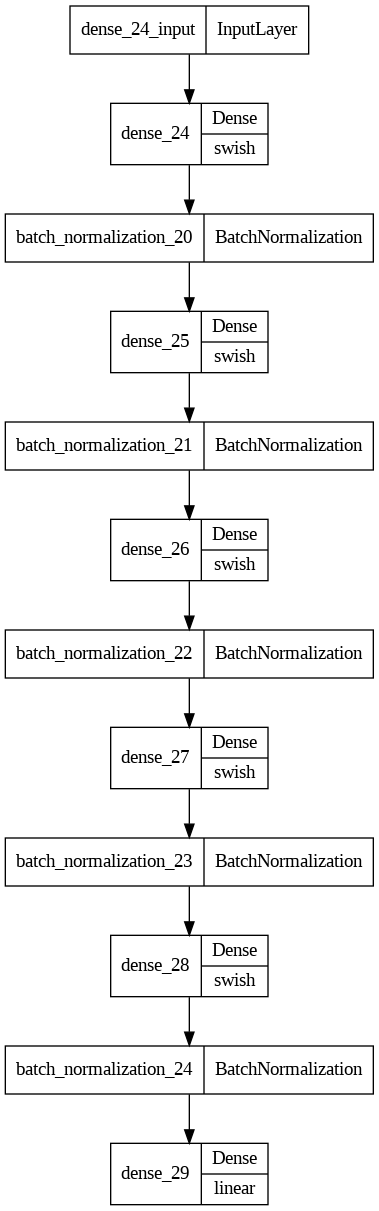

In [ ]:
plot_model(trained_pipelines.get('Deep Neural Network with PSA clusters_spectral_vert_means')['model'], show_layer_activations=True)

In [ ]:
history_dnn.keys()

dict_keys(['Deep Neural Network with PSA clusters_spectral_coefs', 'Deep Neural Network with PSA clusters_spectral_means', 'Deep Neural Network with PSA clusters_spectral_horiz_means', 'Deep Neural Network with PSA clusters_spectral_vert_means'])

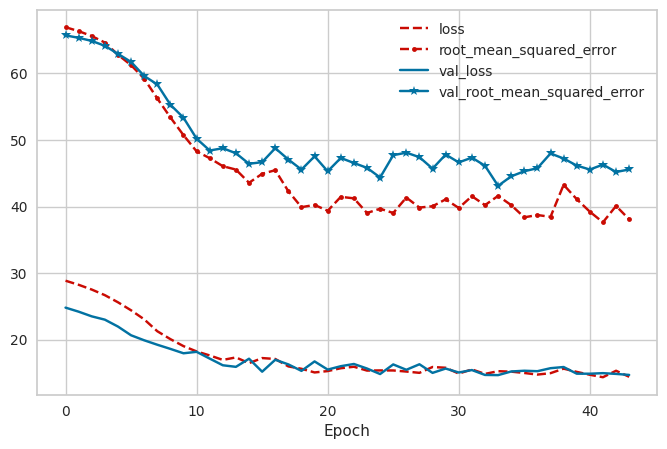

In [ ]:
pd.DataFrame(history_dnn['Deep Neural Network with PSA clusters_spectral_means'].history).plot(
    figsize=(8, 5),  grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [ ]:
len(trained_pipelines)

25

In [ ]:
experiments_results_filename = f'{project_path}/paper_1_results/experiments_results.pickle'
with open(experiments_results_filename, 'wb') as f:
    pickle.dump(experiments, f)

In [ ]:
trained_pipelines_copy = trained_pipelines.copy()

trained_pipelines_path = f'{project_path}/paper_1_results/trained_pipelines/'
for pipeline_name in list(trained_pipelines_copy.keys()):
  print(pipeline_name)
  pipeline = trained_pipelines_copy.get(pipeline_name)
  filename = f'{trained_pipelines_path}{pipeline_name}.joblib'
  if(pipeline_name.startswith('Deep Neural Network')):
    pipeline.named_steps['model'].save(f'{trained_pipelines_path}{pipeline_name}.h5')
    pipeline.steps.pop(1)

  joblib.dump(pipeline, filename)




Linear Regression
Polynomial Regression
Polynomial ElasticNet
Random Forest
Deep Neural Network


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Linear Regression with PSA clusters_spectral_coefs
Polynomial Regression with PSA clusters_spectral_coefs
Polynomial ElasticNet with PSA clusters_spectral_coefs
Random Forest with PSA clusters_spectral_coefs
Deep Neural Network with PSA clusters_spectral_coefs
Linear Regression with PSA clusters_spectral_means
Polynomial Regression with PSA clusters_spectral_means
Polynomial ElasticNet with PSA clusters_spectral_means
Random Forest with PSA clusters_spectral_means
Deep Neural Network with PSA clusters_spectral_means
Linear Regression with PSA clusters_spectral_horiz_means
Polynomial Regression with PSA clusters_spectral_horiz_means
Polynomial ElasticNet with PSA clusters_spectral_horiz_means
Random Forest with PSA clusters_spectral_horiz_means
Deep Neural Network with PSA clusters_spectral_horiz_means
Linear Regression with PSA clusters_spectral_vert_means
Polynomial Regression with PSA clusters_spectral_vert_means
Polynomial ElasticNet with PSA clusters_spectral_vert_means
Random Fore

##experiment analysis

In [ ]:
experiments_results_filename = f'{project_path}/paper_1_results/experiments_results.pickle'
with open(experiments_results_filename, 'rb') as f:
    experiments = pickle.load(f)

In [ ]:
trained_pipelines_path = f'{project_path}/paper_1_results/trained_pipelines/'

#res=[]
trained_pipelines = {}

for file_path in os.listdir(trained_pipelines_path):
    # check if current file_path is a file
    if os.path.isfile(os.path.join(trained_pipelines_path, file_path)):
        # add filename to list
        #res.append(file_path)
        #print(f'file_path: {file_path}')
        if(file_path.split('.')[1]=='joblib'):
          pipeline_name = file_path.split('.')[0]
          print(pipeline_name)
          pipeline_filename_path = f'{trained_pipelines_path}{file_path}'
          pipeline = joblib.load(pipeline_filename_path)
          if(pipeline_name.startswith('Deep Neural Network')):
            dnn_model = load_model(f'{trained_pipelines_path}{pipeline_name}.h5', compile = False)
            #clf = KerasRegressor(build_fn=dnn_model, verbose=0)
            pipeline.steps.append(['model', dnn_model])
          #with open(pipeline_filename_path, 'rb') as f:
          #  pipeline = pickle.load(f)
        trained_pipelines[pipeline_name] = pipeline

#print(res)

Linear Regression
Polynomial ElasticNet
Polynomial Regression
Random Forest
Linear Regression with PSA clusters_spectral_coefs
Polynomial Regression with PSA clusters_spectral_coefs
Deep Neural Network
Polynomial ElasticNet with PSA clusters_spectral_coefs
Random Forest with PSA clusters_spectral_coefs
Polynomial ElasticNet with PSA clusters_spectral_means
Linear Regression with PSA clusters_spectral_means
Deep Neural Network with PSA clusters_spectral_coefs
Polynomial Regression with PSA clusters_spectral_means
Random Forest with PSA clusters_spectral_means
Polynomial Regression with PSA clusters_spectral_horiz_means
Polynomial ElasticNet with PSA clusters_spectral_horiz_means
Linear Regression with PSA clusters_spectral_horiz_means
Deep Neural Network with PSA clusters_spectral_means
Random Forest with PSA clusters_spectral_horiz_means
Deep Neural Network with PSA clusters_spectral_horiz_means
Polynomial Regression with PSA clusters_spectral_vert_means
Linear Regression with PSA clus

In [ ]:
len(trained_pipelines)

25

In [ ]:
df_experiments = pd.DataFrame(experiments.values())
df_experiments['Description'] = experiments.keys()
df_experiments.columns = ['rmse', 'r2', 'CI Lower Bound','CI Upper Bound' ,'Description']
df_experiments = df_experiments[['Description', 'rmse', 'r2', 'CI Lower Bound','CI Upper Bound' ]]

In [ ]:
df_experiments.sort_values(by='rmse')

Description       rmse        r2  \
13     Random Forest with PSA clusters_spectral_means  31.186238  0.756624   
18  Random Forest with PSA clusters_spectral_horiz...  31.869461  0.745844   
23  Random Forest with PSA clusters_spectral_vert_...  33.763850  0.714731   
14  Deep Neural Network with PSA clusters_spectral...  34.355702  0.704642   
3                                       Random Forest  34.824290  0.696530   
24  Deep Neural Network with PSA clusters_spectral...  35.977134  0.676105   
21  Polynomial Regression with PSA clusters_spectr...  37.620428  0.645841   
11  Polynomial Regression with PSA clusters_spectr...  37.620428  0.645841   
19  Deep Neural Network with PSA clusters_spectral...  37.631634  0.645630   
4                                 Deep Neural Network  37.865454  0.641212   
22  Polynomial ElasticNet with PSA clusters_spectr...  38.812912  0.623033   
16  Polynomial Regression with PSA clusters_spectr...  38.953395  0.620299   
17  Polynomial ElasticNet with PSA clusters_spectr...  39.693859  0.605726   
12  Polynomial ElasticNet with PSA clusters_spectr...  40.141448  0.596785   
1                               Polynomial Regression  40.321143  0.593166   
8      Random Forest with PSA clusters_spectral_coefs  40.682704  0.585838   
9   Deep Neural Network with PSA clusters_spectral...  40.909734  0.581202   
7   Polynomial ElasticNet with PSA clusters_spectr...  41.420113  0.570687   
2                               Polynomial ElasticNet  41.993807  0.558713   
6   Polynomial Regression with PSA clusters_spectr...  42.741609  0.542856   
20  Linear Regression with PSA clusters_spectral_v...  45.382939  0.484610   
10  Linear Regression with PSA clusters_spectral_m...  45.861116  0.473692   
15  Linear Regression with PSA clusters_spectral_h...  46.045250  0.469457   
5   Linear Regression with PSA clusters_spectral_c...  46.191794  0.466074   
0                                   Linear Regression  46.411422  0.460985   

    CI Lower Bound  CI Upper Bound  
13       23.931694       37.046415  
18       24.896030       37.570104  
23       25.695500       40.245950  
14       22.638016       42.990100  
3        26.601875       41.446381  
24       23.481394       45.136820  
21       27.469313       45.563474  
11       27.469313       45.563474  
19       24.816033       47.079128  
4        25.110059       47.297677  
22       28.854096       46.693955  
16       28.999920       46.837364  
17       30.131898       47.363210  
12       29.956959       48.220870  
1        29.413416       48.851203  
8        29.773393       49.231188  
9        28.268070       50.478995  
7        30.317469       50.120881  
2        31.226816       50.515795  
6        30.216325       52.351351  
20       34.137795       54.349179  
10       34.531198       54.900640  
15       34.879850       54.988419  
5        34.487208       55.479691  
0        34.965607       55.546797

com split estratificado por distancia epicentral, o melhor r ficou 0,76

In [ ]:
len(trained_pipelines)

25

In [ ]:
trained_pipelines.keys()

dict_keys(['Polynomial Regression', 'Linear Regression', 'Polynomial ElasticNet', 'Random Forest', 'Linear Regression with PSA clusters_spectral_coefs', 'Deep Neural Network', 'Polynomial Regression with PSA clusters_spectral_coefs', 'Polynomial ElasticNet with PSA clusters_spectral_coefs', 'Random Forest with PSA clusters_spectral_coefs', 'Polynomial ElasticNet with PSA clusters_spectral_means', 'Deep Neural Network with PSA clusters_spectral_coefs', 'Linear Regression with PSA clusters_spectral_means', 'Polynomial Regression with PSA clusters_spectral_means', 'Random Forest with PSA clusters_spectral_means', 'Deep Neural Network with PSA clusters_spectral_means', 'Polynomial Regression with PSA clusters_spectral_horiz_means', 'Linear Regression with PSA clusters_spectral_horiz_means', 'Polynomial ElasticNet with PSA clusters_spectral_horiz_means', 'Polynomial Regression with PSA clusters_spectral_vert_means', 'Linear Regression with PSA clusters_spectral_vert_means', 'Deep Neural Net

In [ ]:
df_experiments.loc[14].Description

'Deep Neural Network with PSA clusters_spectral_means'

Linear Regression
1
Polynomial ElasticNet
1
Polynomial Regression
1
Random Forest
1
Deep Neural Network
11/11 [==============================] - 0s 23ms/step
2


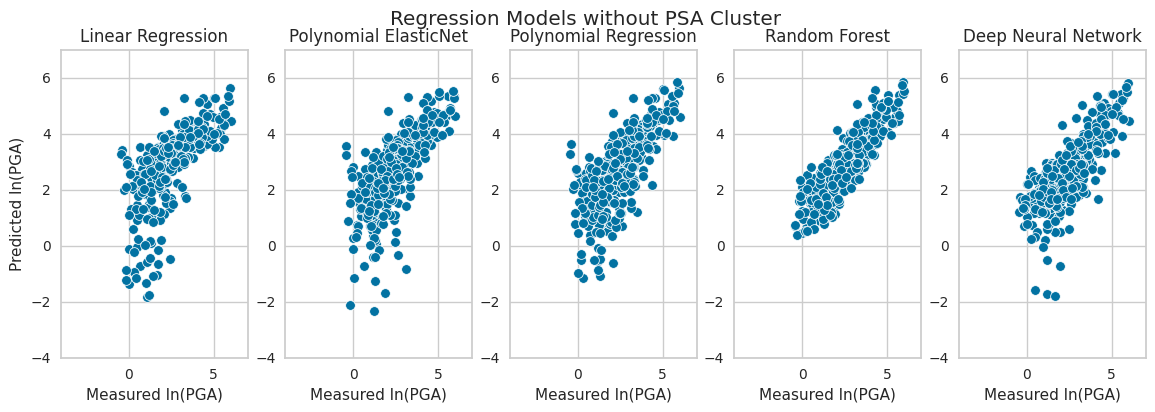

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(14, 4))
fig.suptitle('Regression Models without PSA Cluster')

for i in range(5):
  pipeline_name = list(trained_pipelines.keys())[i]
  print(pipeline_name)
  test_pred = trained_pipelines[pipeline_name].predict(test_set)
  print(len(test_pred.shape))
  if(len(test_pred.shape)>1):
    test_pred = test_pred[:, 0]
  sns.scatterplot(ax=axes[i], x=np.log(test_set['peak_ground_acceleration']), y=np.log(np.abs(test_pred)))
  axes[i].set_xlabel('Measured ln(PGA)')
  if(i==0):
    axes[i].set_ylabel('Predicted ln(PGA)')
  axes[i].set_xlim(-4,7)
  axes[i].set_ylim(-4,7)
  axes[i].set_title(pipeline_name)

#sns.scatterplot(ax=axes[1], x=test_set['epicentral_distance'], y=np.log(np.abs(test_set['peak_ground_acceleration'] - test_pred2)))
#axes[1].set_xlabel('Epicentral Distance (km)')
#axes[1].set_ylabel('ln(PGA error)')

In [ ]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('standardize',
                                                  StandardScaler())]),
                                 ['magnitude', 'calculated_epicentral_distance',
                                  'depth', 'calculated_incidence_angle',
                                  'calculated_hypocentral_distance',
                                  'calculated_azimuth', 'source_off_shore',
                                  'log_incidence_angle'])])

In [ ]:
steps = [
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=polynomial_include_bias)),
    ('model', LinearRegression())
]

pipeline = Pipeline(steps)

#pipeline.fit(train_set, train_set['peak_ground_acceleration'])
model_name = 'Polynomial Regression'
test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)

trained_pipelines[model_name] = pipeline

#experiments['Polynomial Regression'] = [test_rmse, r2]

#experiments

Polynomial ElasticNet with PSA clusters_spectral_means
Polynomial ElasticNet 
11/11 [==============================] - 1s 39ms/step
Deep Neural Network with PSA clusters_spectral_coefs
Deep Neural Network 
Linear Regression with PSA clusters_spectral_means
Linear Regression 
Random Forest with PSA clusters_spectral_means
Random Forest 
11/11 [==============================] - 1s 39ms/step
Deep Neural Network with PSA clusters_spectral_means
Deep Neural Network 


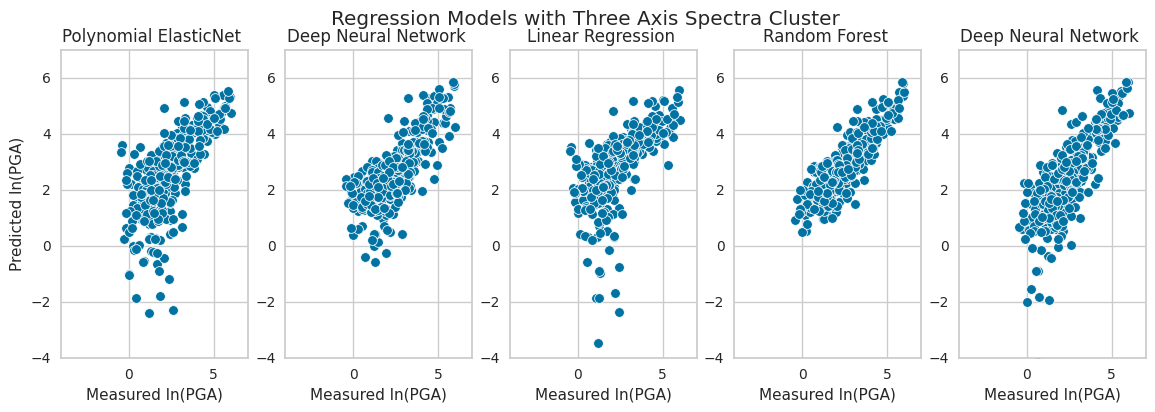

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(14, 4))
fig.suptitle('Regression Models with Three Axis Spectra Cluster')

for i in range(5):
  index = i+10
  pipeline_name = list(trained_pipelines.keys())[index]
  test_pred = trained_pipelines[pipeline_name].predict(test_set)
  print(pipeline_name)
  plot_title = pipeline_name.split('with')[0]
  print(plot_title)

  #if i==1:
    #print(test_pred.shape)
    #print(test_pred)

  if(len(test_pred.shape)>1):
    test_pred = test_pred[:, 0]
  #sns.scatterplot(ax=axes[i], x=test_set['peak_ground_acceleration'], y=np.abs(test_pred)) #y=np.log(np.abs(test_pred)))
  sns.scatterplot(ax=axes[i], x=np.log(test_set['peak_ground_acceleration']), y=np.log(np.abs(test_pred)))
  axes[i].set_xlabel('Measured ln(PGA)')
  if(i==0):
    axes[i].set_ylabel('Predicted ln(PGA)')
  axes[i].set_xlim(-4,7)
  axes[i].set_ylim(-4,7)
  axes[i].set_title(plot_title)

#sns.scatterplot(ax=axes[1], x=test_set['epicentral_distance'], y=np.log(np.abs(test_set['peak_ground_acceleration'] - test_pred2)))
#axes[1].set_xlabel('Epicentral Distance (km)')
#axes[1].set_ylabel('ln(PGA error)')

In [ ]:
selected_cluster_column = 'clusters_spectral_means'
model_name = f'Polynomial Regression with PSA {selected_cluster_column}'
print(model_name)

steps = [
    ('preprocessor', preprocessor_with_psa_cluster),
    ('poly', PolynomialFeatures(degree=2, include_bias=polynomial_include_bias)),
    ('model', LinearRegression())
]

pipeline = Pipeline(steps)

test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)
trained_pipelines[model_name] = pipeline



Polynomial Regression with PSA clusters_spectral_means


### Random Forest

In [ ]:
trained_pipelines.keys()

dict_keys(['Linear Regression', 'Polynomial ElasticNet', 'Polynomial Regression', 'Random Forest', 'Linear Regression with PSA clusters_spectral_coefs', 'Polynomial Regression with PSA clusters_spectral_coefs', 'Deep Neural Network', 'Polynomial ElasticNet with PSA clusters_spectral_coefs', 'Random Forest with PSA clusters_spectral_coefs', 'Polynomial ElasticNet with PSA clusters_spectral_means', 'Linear Regression with PSA clusters_spectral_means', 'Deep Neural Network with PSA clusters_spectral_coefs', 'Polynomial Regression with PSA clusters_spectral_means', 'Random Forest with PSA clusters_spectral_means', 'Polynomial Regression with PSA clusters_spectral_horiz_means', 'Polynomial ElasticNet with PSA clusters_spectral_horiz_means', 'Linear Regression with PSA clusters_spectral_horiz_means', 'Deep Neural Network with PSA clusters_spectral_means', 'Random Forest with PSA clusters_spectral_horiz_means', 'Deep Neural Network with PSA clusters_spectral_horiz_means', 'Polynomial Regressi

In [ ]:
pipeline_RF_without_clustering = trained_pipelines['Random Forest']
pipeline_RF_with_clustering = trained_pipelines['Random Forest with PSA clusters_spectral_means']


In [ ]:
test_pred1 = pipeline_RF_without_clustering.predict(test_set)
test_pred2 = pipeline_RF_with_clustering.predict(test_set)

percent_error_1 = (test_set['peak_ground_acceleration'] - test_pred1) / test_set['peak_ground_acceleration']
percent_error_2 = (test_set['peak_ground_acceleration'] - test_pred2) / test_set['peak_ground_acceleration']

Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

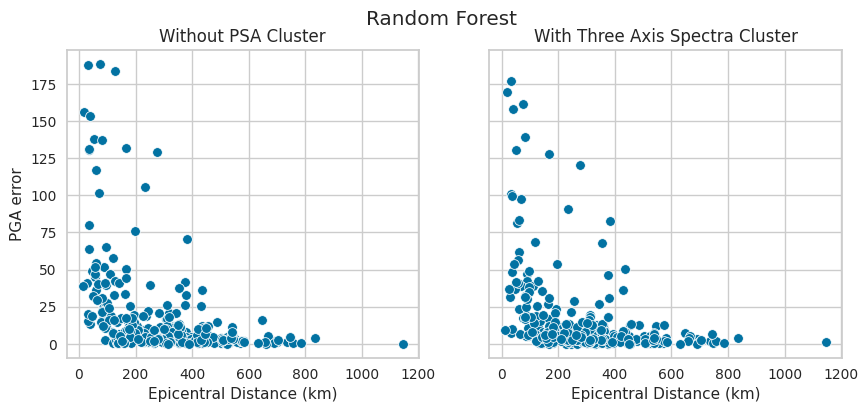

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['calculated_epicentral_distance'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred1)))
axes[0].set_xlabel('Epicentral Distance (km)')
axes[0].set_ylabel('PGA error')
axes[0].set_title('Without PSA Cluster')

sns.scatterplot(ax=axes[1], x=test_set['calculated_epicentral_distance'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred2)))
axes[1].set_xlabel('Epicentral Distance (km)')
axes[1].set_ylabel('PGA error')
axes[1].set_title('With Three Axis Spectra Cluster')


Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

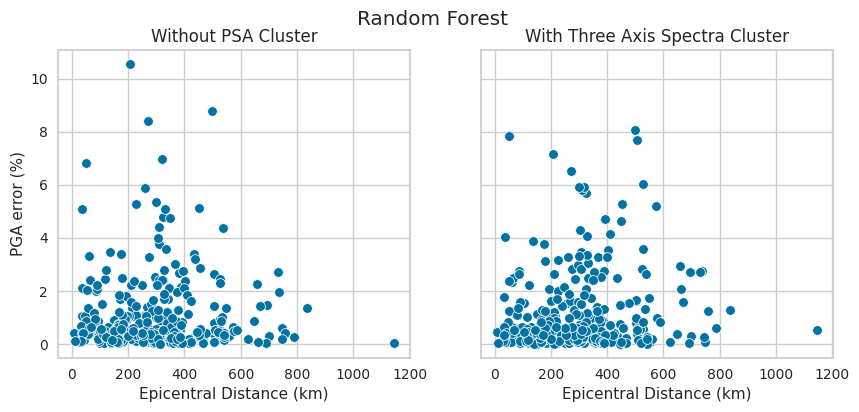

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['calculated_epicentral_distance'], y=np.abs(percent_error_1))
axes[0].set_xlabel('Epicentral Distance (km)')
axes[0].set_ylabel('PGA error (%)')
axes[0].set_title('Without PSA Cluster')

sns.scatterplot(ax=axes[1], x=test_set['calculated_epicentral_distance'], y=np.abs(percent_error_2))
axes[1].set_xlabel('Epicentral Distance (km)')
axes[1].set_ylabel('PGA error (%)')
axes[1].set_title('With Three Axis Spectra Cluster')


Text(0.5, 0.98, 'Random Forest Without PSA Cluster')

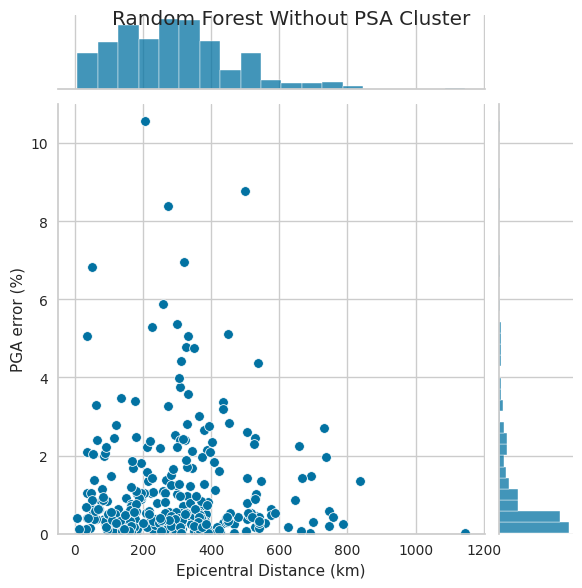

In [ ]:
#sns.scatterplot(ax=axes[0], x=test_set['epicentral_distance'], y=np.abs(percent_error_1))
jointgrid =sns.jointplot(x=test_set['calculated_epicentral_distance'], y=np.abs(percent_error_1), ylim=(0,11))
jointgrid.set_axis_labels(xlabel='Epicentral Distance (km)', ylabel='PGA error (%)')
jointgrid.fig.suptitle('Random Forest Without PSA Cluster')
#axes[0].set_xlabel('Epicentral Distance (km)')
#axes[0].set_ylabel('PGA error (%)')
#axes[0].set_title('Without PSA Cluster')





Text(0.5, 0.98, 'Random Forest With Three Axis Spectra Cluster')

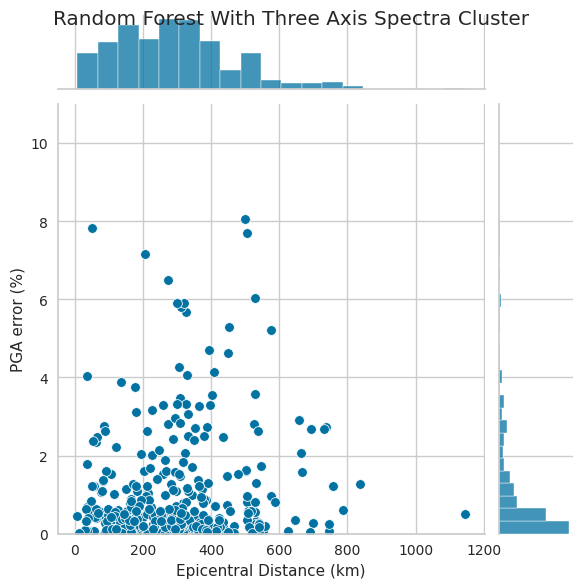

In [ ]:
jointgrid =sns.jointplot(x=test_set['calculated_epicentral_distance'], y=np.abs(percent_error_2), ylim=(0,11))
jointgrid.set_axis_labels(xlabel='Epicentral Distance (km)', ylabel='PGA error (%)')
jointgrid.fig.suptitle('Random Forest With Three Axis Spectra Cluster')
#axes[0].set_xlabel('Epicentral Distance (km)')
#axes[0].set_ylabel('PGA error (%)')
#axes[0].set_title('Without PSA Cluster')

Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

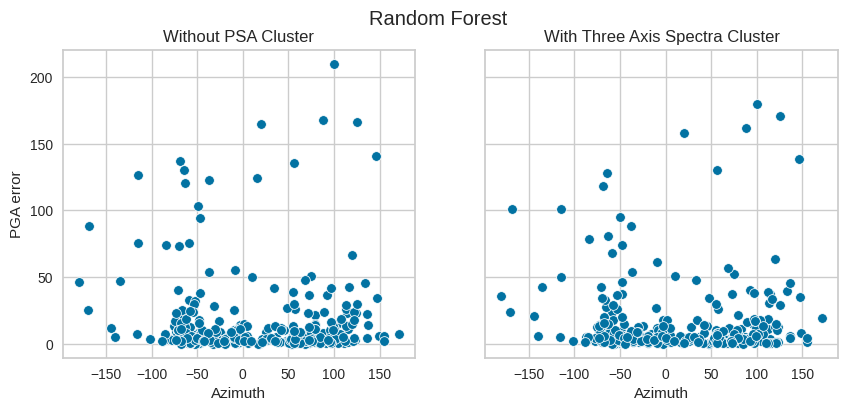

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['calculated_azimuth'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred1)))
axes[0].set_ylabel('PGA error')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Azimuth')

sns.scatterplot(ax=axes[1], x=test_set['calculated_azimuth'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred2)))
axes[1].set_ylabel('PGA error')
axes[1].set_xlabel('Azimuth')
axes[1].set_title('With Three Axis Spectra Cluster')

Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

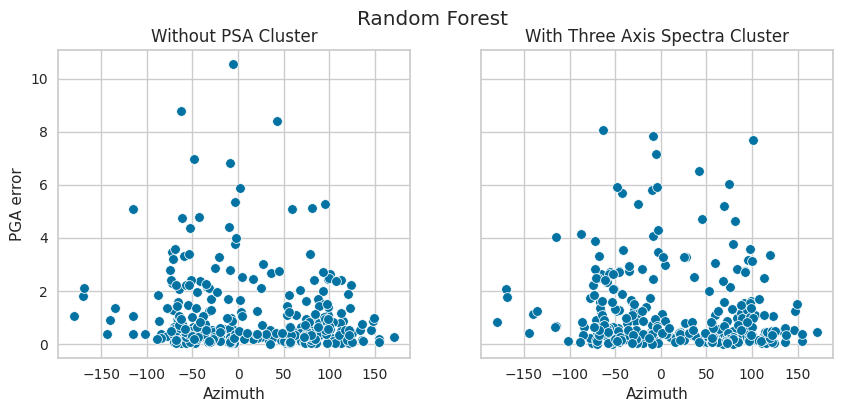

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['calculated_azimuth'], y=(np.abs(percent_error_1)))
axes[0].set_ylabel('PGA error')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Azimuth')

sns.scatterplot(ax=axes[1], x=test_set['calculated_azimuth'], y=(np.abs(percent_error_2)))
axes[1].set_ylabel('PGA error')
axes[1].set_xlabel('Azimuth')
axes[1].set_title('With Three Axis Spectra Cluster')

<bound method Figure.set of <Figure size 600x600 with 3 Axes>>

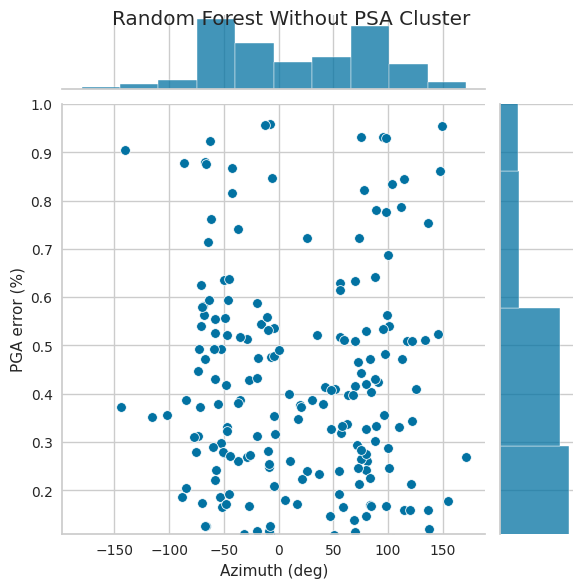

In [ ]:
#sns.scatterplot(ax=axes[0], x=test_set['epicentral_distance'], y=np.abs(percent_error_1))
jointgrid =sns.jointplot(x=test_set['calculated_azimuth'], y=np.abs(percent_error_1), ylim=(0.11))
jointgrid.set_axis_labels(xlabel='Azimuth (deg)', ylabel='PGA error (%)')
jointgrid.fig.suptitle('Random Forest Without PSA Cluster')
jointgrid.fig.set
#axes[0].set_xlabel('Epicentral Distance (km)')
#axes[0].set_ylabel('PGA error (%)')
#axes[0].set_title('Without PSA Cluster')





Text(0.5, 0.98, 'Random Forest With Three Axis Spectra Cluster')

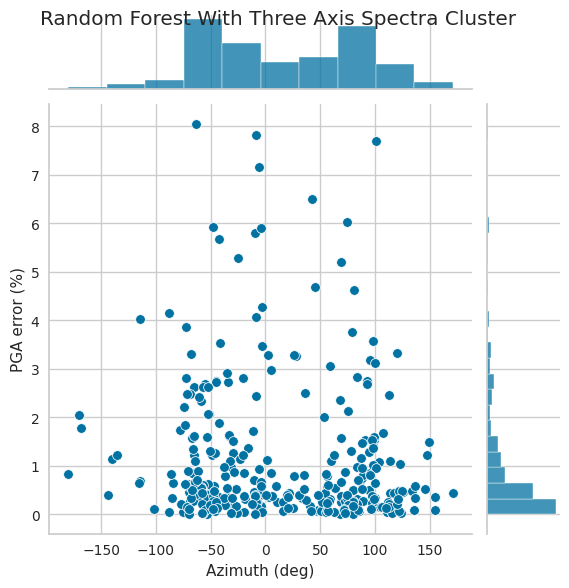

In [ ]:
#sns.scatterplot(ax=axes[0], x=test_set['epicentral_distance'], y=np.abs(percent_error_1))
jointgrid =sns.jointplot(x=test_set['calculated_azimuth'], y=np.abs(percent_error_2))
jointgrid.set_axis_labels(xlabel='Azimuth (deg)', ylabel='PGA error (%)')
jointgrid.fig.suptitle('Random Forest With Three Axis Spectra Cluster')
#axes[0].set_xlabel('Epicentral Distance (km)')
#axes[0].set_ylabel('PGA error (%)')
#axes[0].set_title('Without PSA Cluster')





In [ ]:
test_set.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth',
       'log_incidence_angle', 'magnitude_cat', 'peak_ground_acceleration_cat',
       'calculated_epicentral_distance_cat', 'depth_cat',
       'clusters_spectral_coefs', 'clusters_spectral_means',
       'clusters_spectral_horiz_means', 'clusters_spectral_vert_means'],
      dtype='object')

Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

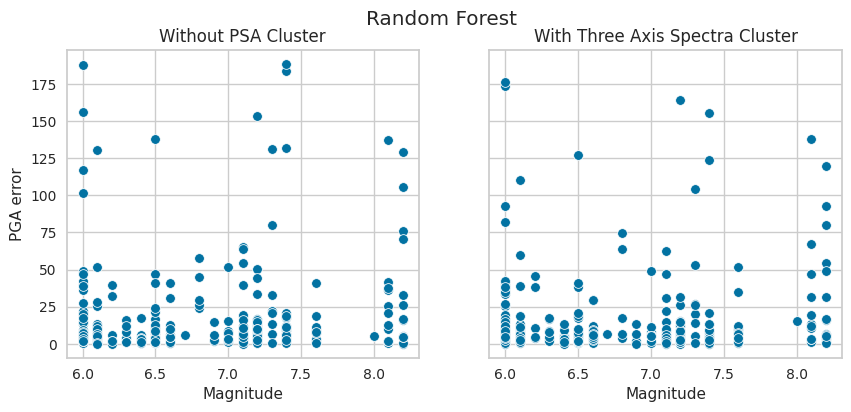

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['magnitude'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred1)))
axes[0].set_ylabel('PGA error')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Magnitude')

sns.scatterplot(ax=axes[1], x=test_set['magnitude'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred2)))
axes[1].set_ylabel('PGA error')
axes[1].set_xlabel('Magnitude')
axes[1].set_title('With Three Axis Spectra Cluster')

Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

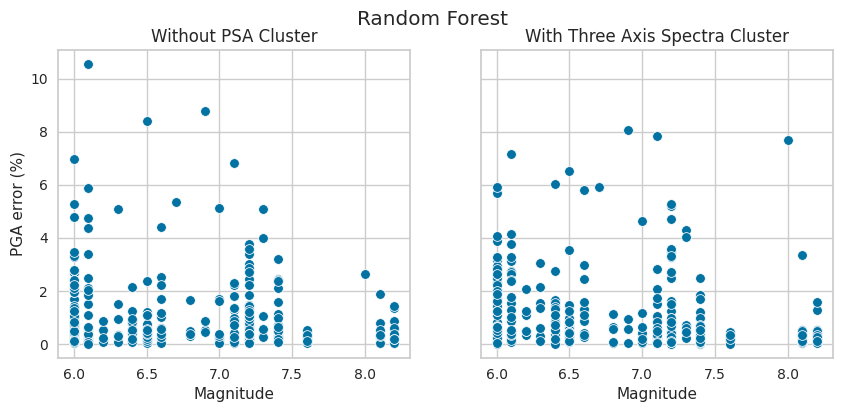

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['magnitude'], y=(np.abs(percent_error_1)))
axes[0].set_ylabel('PGA error (%)')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Magnitude')

sns.scatterplot(ax=axes[1], x=test_set['magnitude'], y=(np.abs(percent_error_2)))
axes[1].set_ylabel('PGA error (%)')
axes[1].set_xlabel('Magnitude')
axes[1].set_title('With Three Axis Spectra Cluster')

Text(0.5, 0.98, 'Random Forest Without PSA Cluster')

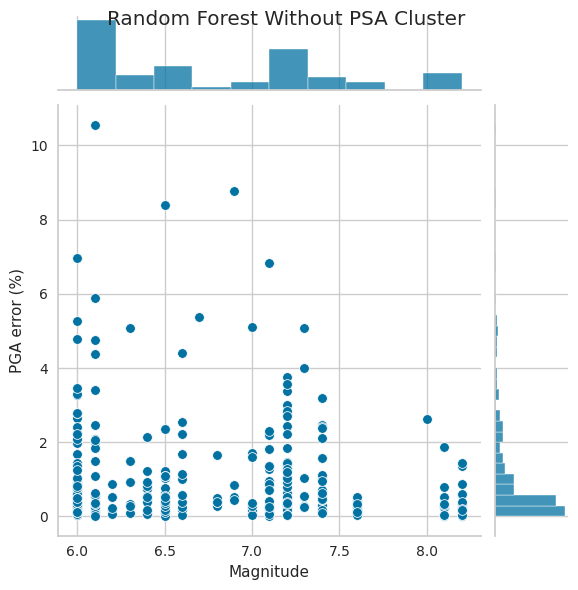

In [ ]:
#sns.scatterplot(ax=axes[0], x=test_set['epicentral_distance'], y=np.abs(percent_error_1))
jointgrid =sns.jointplot(x=test_set['magnitude'], y=np.abs(percent_error_1))
jointgrid.set_axis_labels(xlabel='Magnitude', ylabel='PGA error (%)')
jointgrid.fig.suptitle('Random Forest Without PSA Cluster')
#axes[0].set_xlabel('Epicentral Distance (km)')
#axes[0].set_ylabel('PGA error (%)')
#axes[0].set_title('Without PSA Cluster')





Text(0.5, 0.98, 'Random Forest With Three Axis Spectra Cluster')

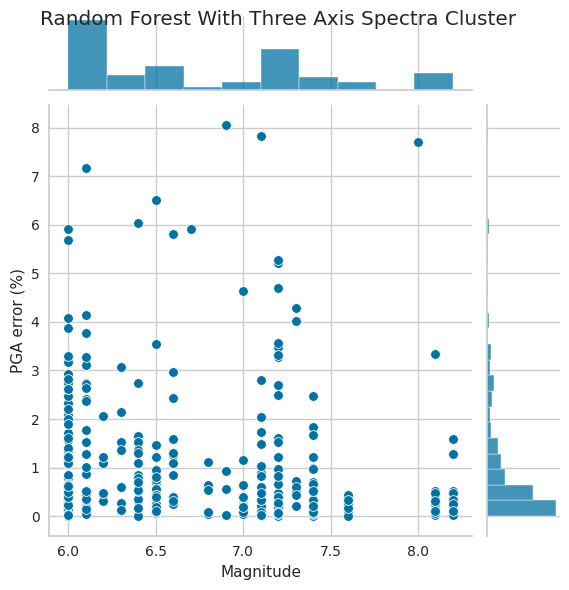

In [ ]:
#sns.scatterplot(ax=axes[0], x=test_set['epicentral_distance'], y=np.abs(percent_error_1))
jointgrid =sns.jointplot(x=test_set['magnitude'], y=np.abs(percent_error_2))
jointgrid.set_axis_labels(xlabel='Magnitude', ylabel='PGA error (%)')
jointgrid.fig.suptitle('Random Forest With Three Axis Spectra Cluster')
#axes[0].set_xlabel('Epicentral Distance (km)')
#axes[0].set_ylabel('PGA error (%)')
#axes[0].set_title('Without PSA Cluster')





Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

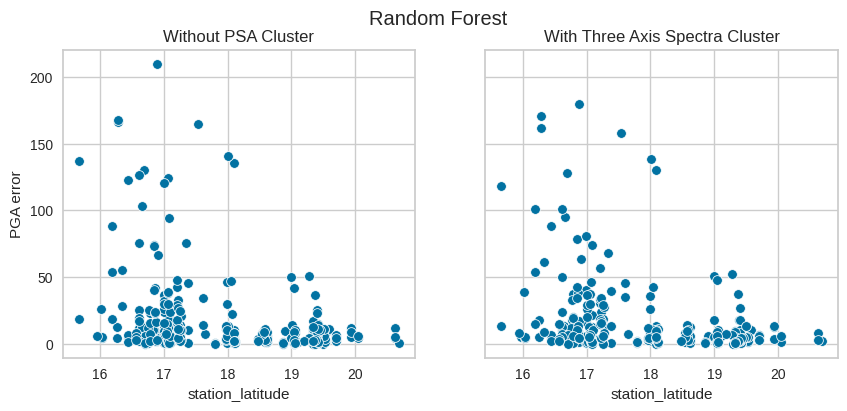

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['station_latitude'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred1)))
axes[0].set_ylabel('PGA error')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('station_latitude')

sns.scatterplot(ax=axes[1], x=test_set['station_latitude'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred2)))
axes[1].set_ylabel('PGA error')
axes[1].set_xlabel('station_latitude')
axes[1].set_title('With Three Axis Spectra Cluster')

Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

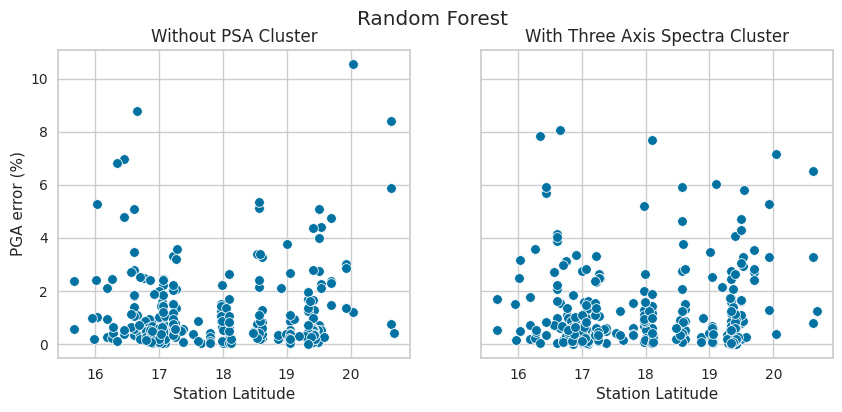

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['station_latitude'], y=(np.abs(percent_error_1)))
axes[0].set_ylabel('PGA error (%)')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Station Latitude')

sns.scatterplot(ax=axes[1], x=test_set['station_latitude'], y=(np.abs(percent_error_2)))
axes[1].set_ylabel('PGA error (%)')
axes[1].set_xlabel('Station Latitude')
axes[1].set_title('With Three Axis Spectra Cluster')

Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

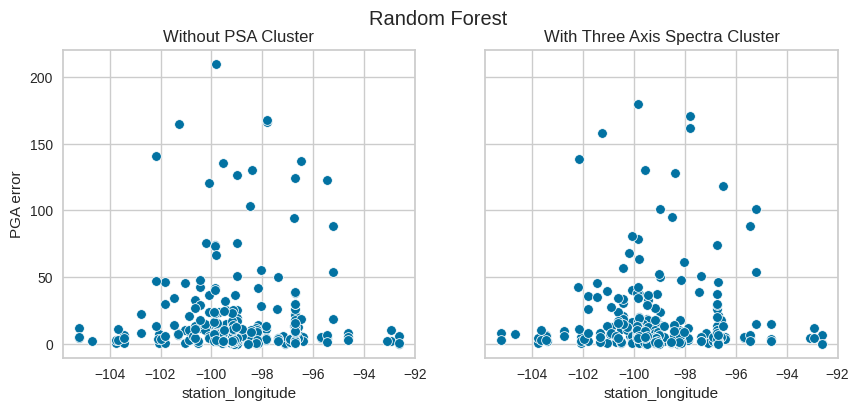

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['station_longitude'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred1)))
axes[0].set_ylabel('PGA error')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('station_longitude')

sns.scatterplot(ax=axes[1], x=test_set['station_longitude'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred2)))
axes[1].set_ylabel('PGA error')
axes[1].set_xlabel('station_longitude')
axes[1].set_title('With Three Axis Spectra Cluster')

Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

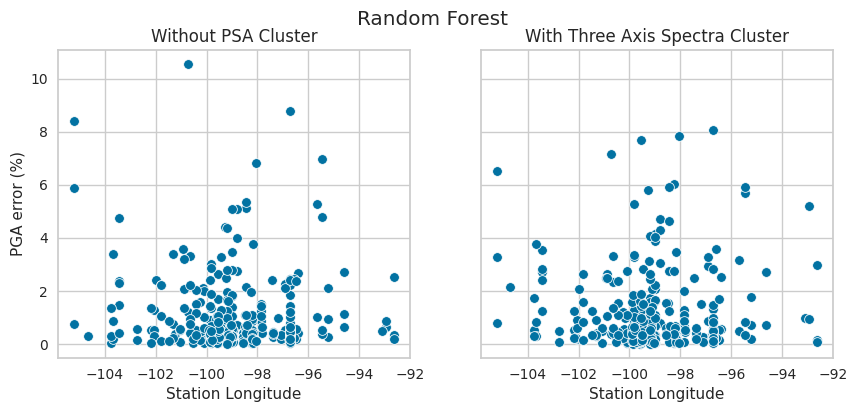

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['station_longitude'], y=(np.abs(percent_error_1)))
axes[0].set_ylabel('PGA error (%)')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Station Longitude')

sns.scatterplot(ax=axes[1], x=test_set['station_longitude'], y=(np.abs(percent_error_2)))
axes[1].set_ylabel('PGA error (%)')
axes[1].set_xlabel('Station Longitude')
axes[1].set_title('With Three Axis Spectra Cluster')

In [ ]:
test_set.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth',
       'log_incidence_angle', 'magnitude_cat', 'peak_ground_acceleration_cat',
       'calculated_epicentral_distance_cat', 'depth_cat',
       'clusters_spectral_coefs', 'clusters_spectral_means',
       'clusters_spectral_horiz_means', 'clusters_spectral_vert_means'],
      dtype='object')

Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

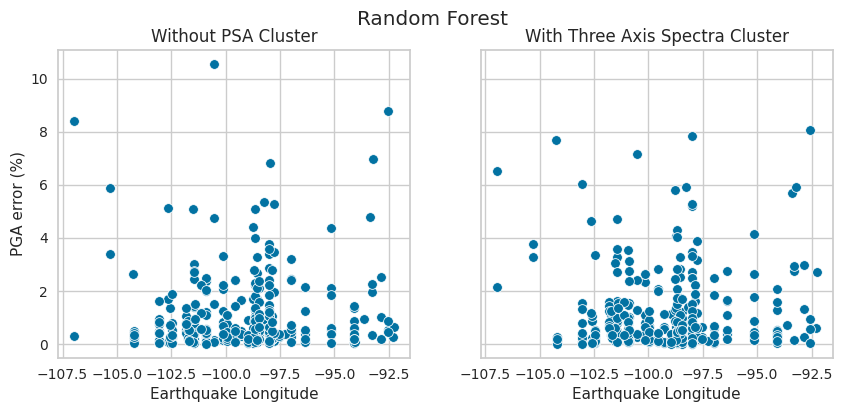

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['earthquake_longitude'], y=(np.abs(percent_error_1)))
axes[0].set_ylabel('PGA error (%)')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Earthquake Longitude')

sns.scatterplot(ax=axes[1], x=test_set['earthquake_longitude'], y=(np.abs(percent_error_2)))
axes[1].set_ylabel('PGA error (%)')
axes[1].set_xlabel('Earthquake Longitude')
axes[1].set_title('With Three Axis Spectra Cluster')

Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

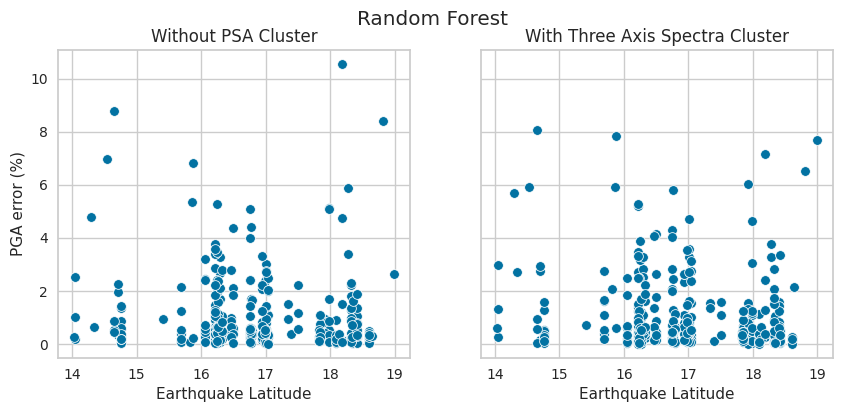

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['earthquake_latitude'], y=(np.abs(percent_error_1)))
axes[0].set_ylabel('PGA error (%)')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Earthquake Latitude')

sns.scatterplot(ax=axes[1], x=test_set['earthquake_latitude'], y=(np.abs(percent_error_2)))
axes[1].set_ylabel('PGA error (%)')
axes[1].set_xlabel('Earthquake Latitude')
axes[1].set_title('With Three Axis Spectra Cluster')

Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

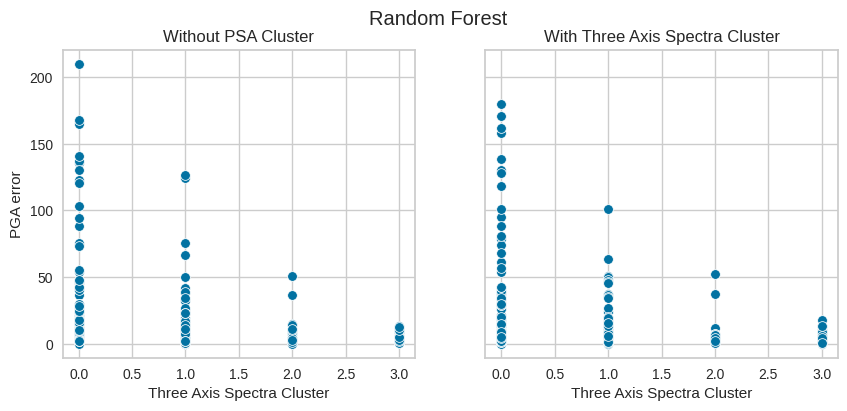

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['clusters_spectral_means'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred1)))
axes[0].set_ylabel('PGA error')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Three Axis Spectra Cluster')

sns.scatterplot(ax=axes[1], x=test_set['clusters_spectral_means'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred2)))
axes[1].set_ylabel('PGA error')
axes[1].set_xlabel('Three Axis Spectra Cluster')
axes[1].set_title('With Three Axis Spectra Cluster')

Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

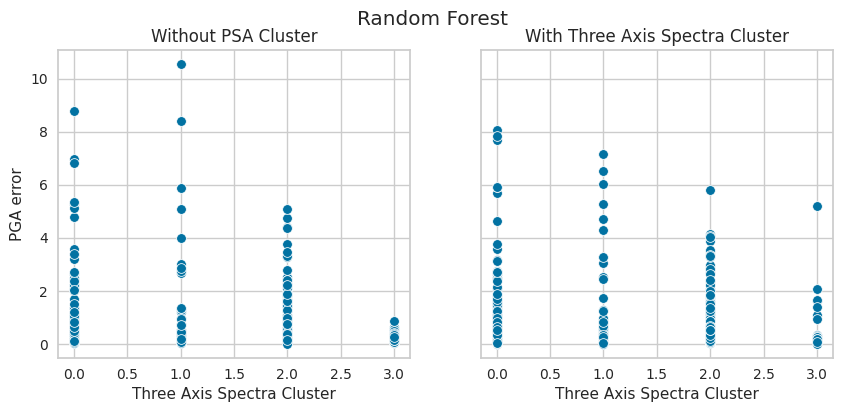

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['clusters_spectral_means'], y=(np.abs(percent_error_1)))
axes[0].set_ylabel('PGA error')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Three Axis Spectra Cluster')

sns.scatterplot(ax=axes[1], x=test_set['clusters_spectral_means'], y=(np.abs(percent_error_2)))
axes[1].set_ylabel('PGA error')
axes[1].set_xlabel('Three Axis Spectra Cluster')
axes[1].set_title('With Three Axis Spectra Cluster')

Text(0.5, 0.98, 'Random Forest Without PSA Cluster')

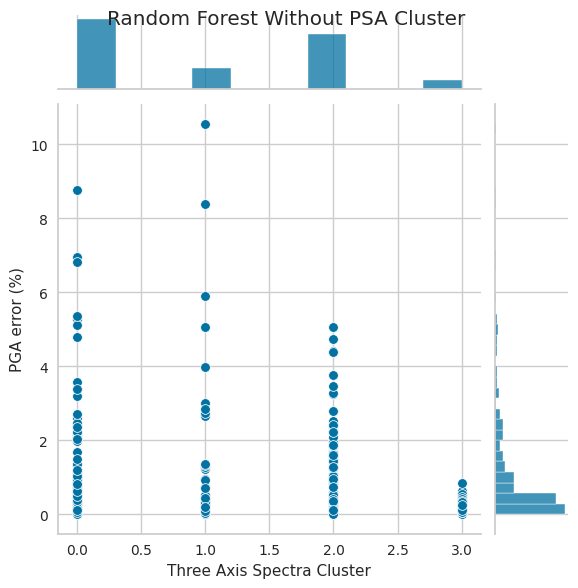

In [ ]:
#sns.scatterplot(ax=axes[0], x=test_set['epicentral_distance'], y=np.abs(percent_error_1))
jointgrid =sns.jointplot(x=test_set['clusters_spectral_means'], y=np.abs(percent_error_1))
jointgrid.set_axis_labels(xlabel='Three Axis Spectra Cluster', ylabel='PGA error (%)')
jointgrid.fig.suptitle('Random Forest Without PSA Cluster')
#axes[0].set_xlabel('Epicentral Distance (km)')
#axes[0].set_ylabel('PGA error (%)')
#axes[0].set_title('Without PSA Cluster')





Text(0.5, 0.98, 'Random Forest With Three Axis Spectra Cluster')

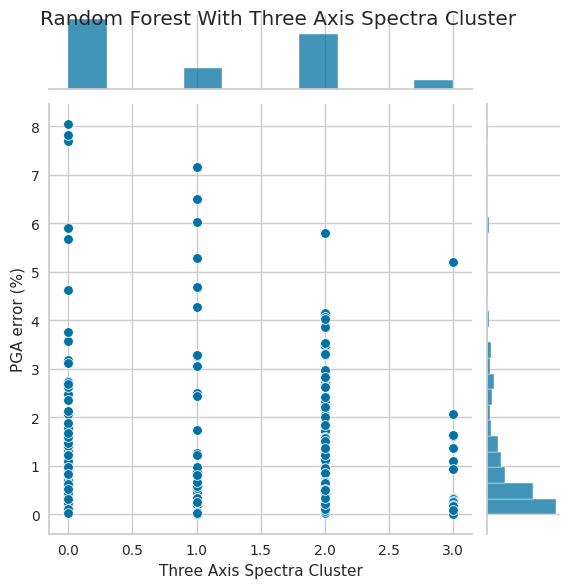

In [ ]:
#sns.scatterplot(ax=axes[0], x=test_set['epicentral_distance'], y=np.abs(percent_error_1))
jointgrid =sns.jointplot(x=test_set['clusters_spectral_means'], y=np.abs(percent_error_2))
jointgrid.set_axis_labels(xlabel='Three Axis Spectra Cluster', ylabel='PGA error (%)')
jointgrid.fig.suptitle('Random Forest With Three Axis Spectra Cluster')
#axes[0].set_xlabel('Epicentral Distance (km)')
#axes[0].set_ylabel('PGA error (%)')
#axes[0].set_title('Without PSA Cluster')





In [ ]:
df_com_clusters.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth',
       'log_incidence_angle', 'magnitude_cat', 'peak_ground_acceleration_cat',
       'calculated_epicentral_distance_cat', 'depth_cat',
       'clusters_spectral_coefs', 'clusters_spectral_means',
       'clusters_spectral_horiz_means', 'clusters_spectral_vert_means'],
      dtype='object')

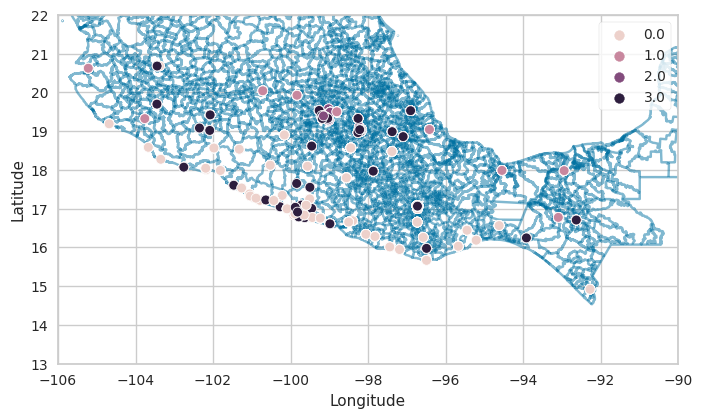

In [ ]:
ax1 = map.plot(figsize=(8,6), alpha=0.5)

g = sns.scatterplot(ax=ax1,
                data=df_com_clusters,
                x='station_longitude',
                y='station_latitude',
                #size='clusters_spectral_means',
                hue='clusters_spectral_means',
                #sizes=(20, 200),
                #marker=(8,1,0),
                s=50,
                zorder=2)
                #palette=sns.color_palette("Reds", as_cmap=True))

#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.legend(frameon=True)

ax1.set(xlabel='Longitude', ylabel='Latitude')
plt.xlim([-106, -90])
plt.ylim([13, 22])

plt.show()

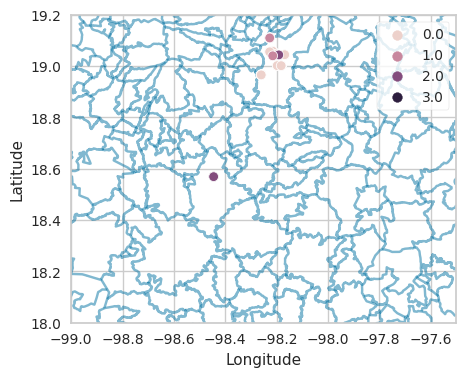

In [ ]:
ax1 = map.plot(figsize=(6,4), alpha=0.5)

g = sns.scatterplot(ax=ax1,
                data=df_com_clusters,
                x='station_longitude',
                y='station_latitude',
                hue='clusters_spectral_means',
                sizes=(40, 200),
                #marker=(8,1,0),
                zorder=2)

#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.legend(frameon=True)

ax1.set(xlabel='Longitude', ylabel='Latitude')

plt.xlim([-99, -97.5])
plt.ylim([18, 19.2])
plt.show()

In [ ]:
df_com_clusters.clusters_spectral_means.value_counts()

0.0    732
3.0    576
1.0    194
2.0    110
Name: clusters_spectral_means, dtype: int64

In [ ]:
df_com_clusters[df_com_clusters.clusters_spectral_means == 3].soil_type.value_counts()

roca                      326
unknown                    34
zona de transicion         34
roca basaltica             29
suelo duro                 27
travertino                 25
roca (cono volcánico)      21
blando                     20
basalto                    19
terreno libre              12
deposito barra             11
depósitos lacustres         8
arcilla                     4
relleno semicompactado      4
roca fracturada             2
Name: soil_type, dtype: int64

In [ ]:
test_set

date      time  magnitude  institution entity station_key  \
492  1998-02-03  03:02:01        6.4  I de I-UNAM    PUE        RABO   
1083 2017-09-23  12:53:04        6.1  I de I-UNAM    OAX        OAXM   
764  1999-09-30  16:31:14        7.4  I de I-UNAM    GRO        COPL   
755  2017-09-08  04:49:17        8.2  I de I-UNAM    COL        COMA   
817  2011-12-11  01:47:25        6.5  I de I-UNAM    PUE        CHFL   
...         ...       ...        ...          ...    ...         ...   
1335 2016-05-08  07:33:59        6.0  I de I-UNAM    GRO        ACAR   
1544 2010-06-30  07:22:27        6.0  I de I-UNAM    OAX        PNTP   
880  2012-03-20  18:02:47        7.4  I de I-UNAM    OAX        JAMI   
1365 2016-05-08  07:33:59        6.0  I de I-UNAM    GRO        TNLP   
298  1997-01-11  20:28:27        7.1  I de I-UNAM    DIF        PENR   

                     station_name  peak_ground_acceleration quality  \
492                        RABOSO                      1.62       A   
1083  OAXACA FACULTAD DE MEDICINA                     43.85       B   
764                        COPALA                     30.14       A   
755                        COMALA                      3.02       A   
817           CHILA DE LAS FLORES                      5.42       A   
...                           ...                       ...     ...   
1335        ACAPULCO RENACIMIENTO                      5.90       A   
1544            PINOTEPA NACIONAL                    353.43       A   
880                    JAMILTEPEC                    293.51       A   
1365             TONALAPA DEL SUR                      2.47       A   
298          COLONIA QUETZALCOATL                     14.83       A   

              file  ...  calculated_azimuth log_incidence_angle  \
492   RABO9802.031  ...          -34.426628            1.582179   
1083  OAXM1709.232  ...          -68.599093            1.942469   
764   COPL9909.301  ...          -73.540856            1.424078   
755   COMA1709.081  ...          -62.476390            0.830859   
817   CHFL1112.111  ...           85.983291            2.613639   
...            ...  ...                 ...                 ...   
1335  ACAR1605.081  ...          -73.036990            2.210218   
1544  PNTP1006.301  ...          -31.470416            3.450975   
880   JAMI1203.202  ...           88.014173            2.582566   
1365  TNLP1605.081  ...          -42.144422            2.015820   
298   PENR9701.111  ...           73.017817            1.770550   

      magnitude_cat  peak_ground_acceleration_cat  \
492               2                             1   
1083              2                             7   
764               4                             7   
755               4                             2   
817               2                             3   
...             ...                           ...   
1335              1                             3   
1544              1                             8   
880               4                             8   
1365              1                             2   
298               3                             5   

      calculated_epicentral_distance_cat depth_cat  clusters_spectral_coefs  \
492                                    5         4                      0.0   
1083                                   2         3                      0.0   
764                                    3         2                      1.0   
755                                    6         4                      3.0   
817                                    3         5                      2.0   
...                                  ...       ...                      ...   
1335                                   3         4                      0.0   
1544                                   1         1                      0.0   
880                                    1         2                      0.0   
1365                                   3         4           

In [ ]:
simulation = test_set[test_set.index == 1083].copy()


In [ ]:
simulation.iloc[0]

date                                                      2017-09-23 00:00:00
time                                                                 12:53:04
magnitude                                                                 6.1
institution                                                       I de I-UNAM
entity                                                                    OAX
station_key                                                              OAXM
station_name                                      OAXACA FACULTAD DE MEDICINA
peak_ground_acceleration                                                43.85
quality                                                                     B
file                                                             OAXM1709.232
epicentral_distance                                                       179
soil_type                                                             aluvial
depth                                                           

In [ ]:
pipeline_RF_with_clustering.predict(simulation)

array([32.20028889])

In [ ]:
simulation.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth',
       'log_incidence_angle', 'magnitude_cat', 'peak_ground_acceleration_cat',
       'calculated_epicentral_distance_cat', 'depth_cat',
       'clusters_spectral_coefs', 'clusters_spectral_means',
       'clusters_spectral_horiz_means', 'clusters_spectral_vert_means'],
      dtype='object')

In [ ]:
simulation.clusters_spectral_means

1083    0.0
Name: clusters_spectral_means, dtype: float64

In [ ]:
simulation = simulation.reset_index(drop=True)
simulation

date      time  magnitude  institution entity station_key  \
0 2017-09-23  12:53:04        6.1  I de I-UNAM    OAX        OAXM   

                  station_name  peak_ground_acceleration quality  \
0  OAXACA FACULTAD DE MEDICINA                     43.85       B   

           file  ...  calculated_azimuth log_incidence_angle  magnitude_cat  \
0  OAXM1709.232  ...          -68.599093            1.942469              2   

   peak_ground_acceleration_cat  calculated_epicentral_distance_cat depth_cat  \
0                             7                                   2         3   

   clusters_spectral_coefs  clusters_spectral_means  \
0                      0.0                      0.0   

   clusters_spectral_horiz_means  clusters_spectral_vert_means  
0                            0.0                           3.0  

[1 rows x 37 columns]

In [ ]:
pred = pipeline_RF_with_clustering.predict(simulation)[0]
simulation['pga_pred'] = pred

for i in range(1,4):
  simulation2 = simulation[simulation.index == 0].copy()
  simulation2.clusters_spectral_means = i
  pred = pipeline_RF_with_clustering.predict(simulation2)[0]
  simulation2['pga_pred'] = pred
  simulation = pd.concat([simulation, simulation2])
  simulation = simulation.reset_index(drop=True)

simulation

date      time  magnitude  institution entity station_key  \
0 2017-09-23  12:53:04        6.1  I de I-UNAM    OAX        OAXM   
1 2017-09-23  12:53:04        6.1  I de I-UNAM    OAX        OAXM   
2 2017-09-23  12:53:04        6.1  I de I-UNAM    OAX        OAXM   
3 2017-09-23  12:53:04        6.1  I de I-UNAM    OAX        OAXM   

                  station_name  peak_ground_acceleration quality  \
0  OAXACA FACULTAD DE MEDICINA                     43.85       B   
1  OAXACA FACULTAD DE MEDICINA                     43.85       B   
2  OAXACA FACULTAD DE MEDICINA                     43.85       B   
3  OAXACA FACULTAD DE MEDICINA                     43.85       B   

           file  ...  log_incidence_angle magnitude_cat  \
0  OAXM1709.232  ...             1.942469             2   
1  OAXM1709.232  ...             1.942469             2   
2  OAXM1709.232  ...             1.942469             2   
3  OAXM1709.232  ...             1.942469             2   

   peak_ground_acceleration_cat  calculated_epicentral_distance_cat  \
0                             7                                   2   
1                             7                                   2   
2                             7                                   2   
3                             7                                   2   

   depth_cat clusters_spectral_coefs  clusters_spectral_means  \
0          3                     0.0                      0.0   
1          3                     0.0                      1.0   
2          3                     0.0                      2.0   
3          3                     0.0                      3.0   

   clusters_spectral_horiz_means  clusters_spectral_vert_means   pga_pred  
0                            0.0                           3.0  32.200289  
1                            0.0                           3.0  11.966528  
2                            0.0                           3.0  11.736289  
3                            0.0                           3.0  20.724543  

[4 rows x 38 columns]

[Text(0, 0.5, 'PGA Predicted')]

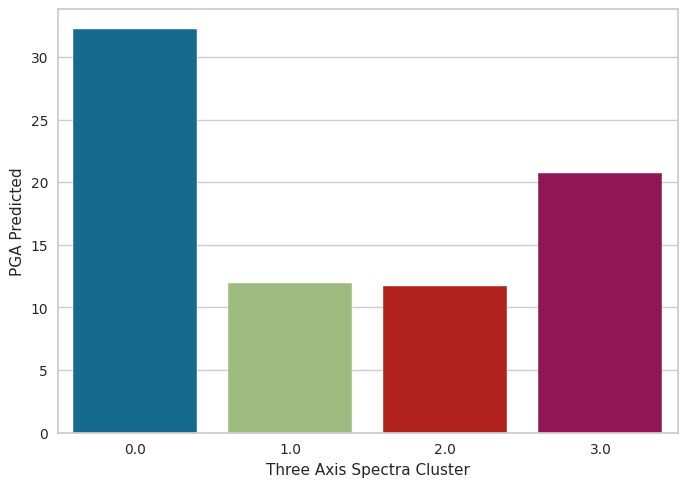

In [ ]:
p = sns.barplot(data=simulation, x="clusters_spectral_means", y="pga_pred")
p.set(xlabel="Three Axis Spectra Cluster")
p.set(ylabel="PGA Predicted")


## GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

In [ ]:
gbrt_best = GradientBoostingRegressor(
max_depth=2, learning_rate=0.05, n_estimators=500,
n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


steps = [
    ('preprocessor', preprocessor),
    #('poly', PolynomialFeatures(degree=3)),
    #('model', LinearRegression())
    ('model', GradientBoostingRegressor(#max_depth=2,
                                        learning_rate=0.5,
                                        n_estimators=500,
                                        n_iter_no_change=10, random_state=42))
    #('model', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000))
]

pipeline = Pipeline(steps)

#pipeline.fit(train_set, train_set['peak_ground_acceleration'])

cros_val_error_mean, cros_val_error_std, pipeline = model_experiment(train_set, pipeline)

predictions = pipeline.predict(test_set)
test_rmse = mean_squared_error(test_set['peak_ground_acceleration'], predictions, squared=False)

print(cros_val_error_mean, cros_val_error_std, test_rmse)

44.75876038120553 4.589430507573825 44.10574133328215
